<a href="https://colab.research.google.com/github/schokoro/AttentionNMT/blob/ir_jap/ir_jap_translate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Первым делом проверим какая карточка нам досталась. Лучшим вариантом будет `Tesla P100-PCIE-16GB`, на остальных будет считаться медленнее.

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cpu':
    raise RuntimeError
else:
    print(torch.cuda.get_device_name(0))

Tesla T4


In [2]:
!pip install janome pandarallel  > /dev/null

In [3]:
!rm -rf AttentionNMT/
!git clone -b ir_jap https://github.com/schokoro/AttentionNMT.git > /dev/null

Cloning into 'AttentionNMT'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 109 (delta 57), reused 55 (delta 23), pack-reused 0
Receiving objects: 100% (109/109), 19.78 MiB | 8.28 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
import sys
sys.path.append('/content/AttentionNMT')

In [5]:
%load_ext autoreload

In [6]:
%reload_ext autoreload
%autoreload 2
import AttentionNMT
from AttentionNMT.transformer import Transformer, Encoder, Decoder
from AttentionNMT.utils import count_parameters, initialize_weights, translate_sentence, evaluate_blue, train, evaluate, display_attention, sentence_blue

In [7]:
%autoreload 2
from typing import Dict, List, Optional
import torch.nn as nn
from matplotlib.font_manager import FontProperties
from torchtext.data import Field, BucketIterator, TabularDataset
from tqdm.notebook import tqdm
from pandarallel import pandarallel
import spacy
import warnings
import re
import random
import math
import time
from janome.tokenizer import Tokenizer as JTokenizer
import seaborn as sns
import numpy as np
import pandas as pd

sns.set()
tqdm.pandas()
warnings.filterwarnings('ignore')
pandarallel.initialize(progress_bar=False)

%matplotlib inline

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Подготовка данных и EDA

## Подготовка корпуса

Посмотрим, как выглядит корпус:

In [9]:
reverse_src = False
reverse_trg = False

In [10]:
nlp = spacy.load("en_core_web_sm")
jt = JTokenizer()
ir_remove = re.compile(r'#ID=.+')
is_token = re.compile(r'\w+')

  
def src_tokenize(text: str, reverse=reverse_src) -> List[str]:
    """
    Токенизирует английский текст, возвращает список токенов.
    """
    tokens = [tok.text for tok in nlp.tokenizer(text)]
    if reverse:
        tokens.reverse()
    return tokens


def trg_tokenize(text: str, reverse=reverse_trg) -> List[str]:
    """
    Токенизирует японский текст, возвращает список токенов в обратном порядке

    """
    tokens = [token.base_form for token in jt.tokenize(text)]
    if reverse:
        tokens.reverse()
    return tokens
  

In [11]:
corpus_df = pd.read_csv('/content/AttentionNMT/corpuses/ir_jap_corpus.csv')

Посчитаем длины предложений в символах и посмотрим их корреляцию.

In [12]:
corpus_df['ir_len'] = corpus_df['ir'].map(lambda x: len(x))
corpus_df['jap_len'] = corpus_df['jap'].map(lambda x: len(x))

In [13]:
corpus_df[['ir_len','jap_len' ]].corr()

,ir_len,jap_len
ir_len,1.000000,0.551159
jap_len,0.551159,1.000000


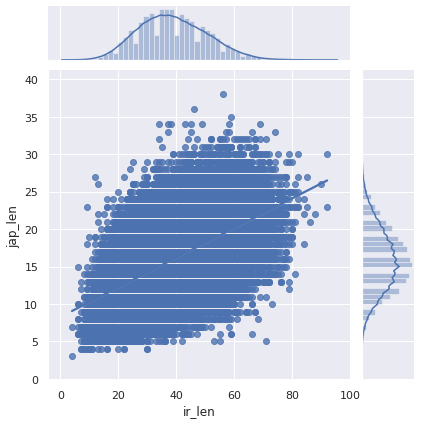

In [14]:
sns.jointplot("ir_len", "jap_len", data=corpus_df, kind="reg");

А теперь - длины предложений в токенах и их корреляцию.

In [15]:
%time corpus_df['ir_tok_len'] = corpus_df['ir'].parallel_apply(lambda x: len(src_tokenize(x)))

CPU times: user 48 ms, sys: 63 ms, total: 111 ms
Wall time: 3.59 s


In [16]:
%time corpus_df['jap_tok_len'] = corpus_df['jap'].parallel_apply(lambda x: len(trg_tokenize(x)))

CPU times: user 85.2 ms, sys: 71.5 ms, total: 157 ms
Wall time: 1min 21s


In [17]:
corpus_df[['ir_tok_len','jap_tok_len' ]].corr()

,ir_tok_len,jap_tok_len
ir_tok_len,1.000000,0.484917
jap_tok_len,0.484917,1.000000


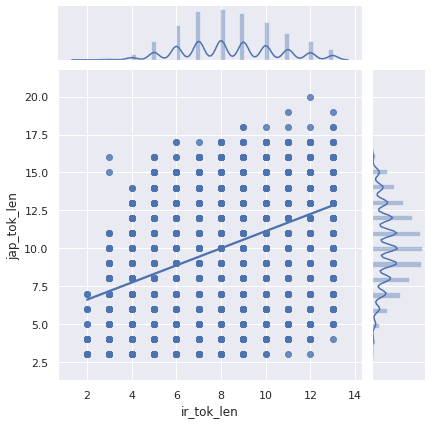

In [18]:
sns.jointplot("ir_tok_len", "jap_tok_len", data=corpus_df, kind="reg")

In [19]:
corpus_df.describe()

,ir_len,jap_len,ir_tok_len,jap_tok_len
count,109045.000000,109045.000000,109045.000000,109045.000000
mean,38.780980,15.960778,8.428227,10.234536
std,11.617382,4.174023,2.186718,2.549087
min,4.000000,3.000000,2.000000,3.000000
25%,30.000000,13.000000,7.000000,8.000000
50%,38.000000,16.000000,8.000000,10.000000
75%,47.000000,19.000000,10.000000,12.000000
max,92.000000,38.000000,13.000000,20.000000


Выбросим из корпуса предложения длиннее чем `quantile(0.9)` и сохраним в файл.

In [20]:
corpus_df.ir_tok_len.quantile(0.9), corpus_df.jap_tok_len.quantile(0.9)

(11.0, 14.0)

In [21]:
new_corpus_df = corpus_df[
    (corpus_df.ir_tok_len < corpus_df.ir_tok_len.quantile(0.99)) &
    (corpus_df.jap_tok_len < corpus_df.jap_tok_len.quantile(0.99)) 
]
new_corpus_df.shape

(100216, 6)

In [22]:
new_corpus_df.describe()

,ir_len,jap_len,ir_tok_len,jap_tok_len
count,100216.000000,100216.000000,100216.000000,100216.000000
mean,37.545981,15.481241,8.170462,9.913936
std,10.890509,3.876920,2.014286,2.330714
min,4.000000,3.000000,2.000000,3.000000
25%,30.000000,13.000000,7.000000,8.000000
50%,37.000000,15.000000,8.000000,10.000000
75%,45.000000,18.000000,10.000000,12.000000
max,88.000000,36.000000,12.000000,14.000000


In [23]:
new_corpus_df.to_csv('ir_jap_corpus.csv', index=None, columns=['ir', 'jap'])

In [24]:
max_src = corpus_df.ir_tok_len.max() + 2
max_trg = corpus_df.jap_tok_len.max() + 2

In [25]:
SRC = Field(
            tokenize = src_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(
            tokenize = trg_tokenize, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [26]:
%%time
trn_data_fields = [("src", SRC), ("trg", TRG)]

dataset = TabularDataset(
    path='ir_jap_corpus.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

CPU times: user 1min 44s, sys: 361 ms, total: 1min 44s
Wall time: 1min 44s


In [27]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [28]:
SRC.build_vocab(train_data.src, min_freq=3)  # 
print(SRC.vocab.freqs.most_common(10))

TRG.build_vocab(train_data.trg, min_freq=3)
print(TRG.vocab.freqs.most_common(10))

print(f'SRC.vocab: {len(SRC.vocab)}, TRG.vocab: {len(TRG.vocab)}')

[('.', 89301), ('an', 40162), ('a', 28302), ('ar', 16955), ('tá', 16902), ('sé', 15093), ('go', 12579), ('ag', 10583), ('is', 9953), ('mé', 8710)]
[('。', 97438), ('は', 73690), ('た', 39951), ('の', 36460), ('を', 36458), ('に', 36400), ('て', 25345), ('が', 22564), ('する', 20425), ('彼', 19708)]
SRC.vocab: 9426, TRG.vocab: 10022


In [29]:
BATCH_SIZE = 256

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.src), # the BucketIterator needs to be told what function it should use to group the data.
    sort_within_batch=False,
    shuffle=True,
    device=device)

# Тренировка модели


In [57]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 128
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 2 * HID_DIM
DEC_PF_DIM = 2 * HID_DIM
ENC_DROPOUT = 0.08
DEC_DROPOUT = 0.08

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              dropout=ENC_DROPOUT, 
              device=device,
              max_length=max_src)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM,
              dropout=DEC_DROPOUT, 
              device=device,
              max_length=max_trg)

In [58]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
try:
    del model
    torch.cuda.empty_cache()
except:
    print('no model')

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

Посчитаем количество параметров сети

In [59]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,778,406 trainable parameters


In [60]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [61]:
model.apply(initialize_weights);
best_macro_bleu = 0
test_loss = np.inf

In [62]:
BEST_MODEL = 'best_blue_ir_jap.pt'

In [63]:
cross_entropy = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
LEARNING_RATE = 1.25e-3
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

def criterion(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return cross_entropy(pred_flat, target_flat)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       factor=0.2,
                                                       verbose=True,
                                                       cooldown=0, 
                                                       patience=4,              
                                                       threshold=0.01,
                                                       min_lr=5e-5)

In [64]:
train_history = []
valid_history = []
blue_history = []

In [65]:
N_EPOCHS = 40
CLIP = 1

try:
    best_valid_loss = evaluate(model, valid_iterator, criterion)
except:
    best_valid_loss = float('inf')
print(f'Loss: {best_valid_loss:7.3f}')


for epoc_num, epoch in tqdm(enumerate(range(N_EPOCHS)), total=N_EPOCHS):
    curent_lr = optimizer.param_groups[0]['lr']
    start_time = time.time()
    try:
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, 1, 1)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        scheduler.step(valid_loss)
                
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            print('Новая лучшая модель')

        macro_bleu = evaluate_blue(valid_data, SRC, TRG, model, device, max_trg, src_tokenize).mean()
        if macro_bleu > best_macro_bleu:
            best_macro_bleu = macro_bleu
            print('Новый лучший blue')            
            torch.save(model.state_dict(), BEST_MODEL)

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        blue_history.append(macro_bleu)

        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        
        print(f'\tMacro-average BLEU: {macro_bleu:.6f}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        print('_' * 100)
    except KeyboardInterrupt:
        print(f"Epoch: {epoch+1:02} | LR: {optimizer.param_groups[0]['lr']}")
        break
    finally:
        pass

Loss:   9.274


Новая лучшая модель
Новый лучший blue
Epoch: 01 | Time: 1m 7s
	Macro-average BLEU: 0.395744
	Train Loss: 3.760 | Train PPL:  42.949
	 Val. Loss: 2.870 |  Val. PPL:  17.641
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 02 | Time: 1m 5s
	Macro-average BLEU: 0.416180
	Train Loss: 2.630 | Train PPL:  13.878
	 Val. Loss: 2.335 |  Val. PPL:  10.333
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 03 | Time: 1m 6s
	Macro-average BLEU: 0.433450
	Train Loss: 2.173 | Train PPL:   8.787
	 Val. Loss: 2.076 |  Val. PPL:   7.973
____________________________________________________________________________________________________
Новая лучшая модель
Новый лучший blue
Epoch: 04 | Time: 1m 7s
	Macro-average BLEU: 0.434589
	Train Loss: 1.890 | Train PPL:   6.618
	 Val. Loss: 1.946 |  Val. PPL:   7.000
_________

    Новый лучший blue
    Epoch: 20 | Time: 1m 10s
	    Macro-average BLEU: 0.479630
	    Train Loss: 0.709 | Train PPL:   2.033
	    Val. Loss: 1.866 |  Val. PPL:   6.466

Загрузим веса модели с наилучшим BLUE

In [39]:
model.load_state_dict(torch.load(BEST_MODEL))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.902 | Test PPL:   6.700 |


## Анализ BLUE

CPU times: user 47.9 s, sys: 199 ms, total: 48.1 s
Wall time: 48.1 s


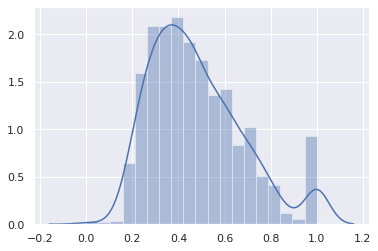

In [40]:
%%time 
valid_bleu = evaluate_blue(valid_data, SRC, TRG, model, device, max_trg, src_tokenize)
sns.distplot(valid_bleu);

CPU times: user 47.3 s, sys: 214 ms, total: 47.5 s
Wall time: 47.5 s


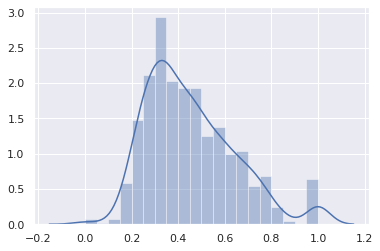

In [41]:
%%time 
test_bleu = evaluate_blue(test_data, SRC, TRG, model, device, max_trg, src_tokenize)
sns.distplot(test_bleu);

In [42]:
valid_bleu.mean(), test_bleu.mean()

(0.47963005877707016, 0.45209744281216974)

# Оценка перевода. Отображение карт внимания.

Для корректного отображения карт внимания загрузим шрифт `Osaka.ttf`. Хотя, можно взять и из репозитория.

In [43]:
!wget -q https://github.com/vuthaihoc/fonts/raw/master/JUSTRAJDEEP/Osaka.ttf

fontprop_x = FontProperties(fname='/content/AttentionNMT/fonts/urchlotrom.ttf', size=20)
fontprop_y = FontProperties(fname='Osaka.ttf', size=20)

src      : bíonn an lóiste ar cíos faoin lá .
trg      : ロッジ は ひる ぎめでかりられる 。
predicted: <unk> は 日 ぎめで 半分 を 借りる て いる 。 <eos>
     blue: 58.48%


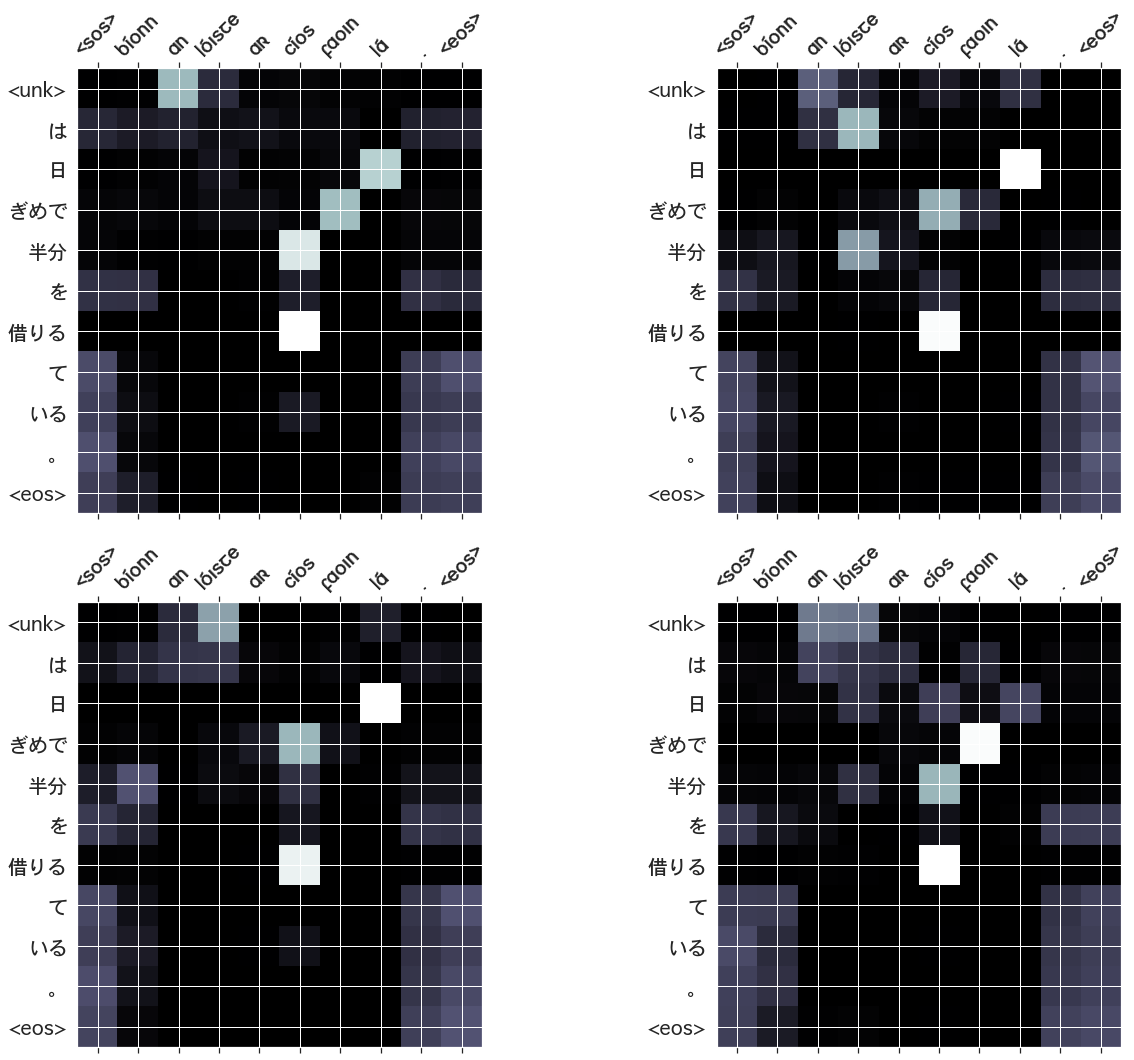

In [44]:
example_idx = random.randint(0, len(train_data) - 1)

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()

if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

src      : táimid ag dul ar thuras an mhí seo chugainn .
trg      : 私 達 は 来月 旅行 に いく つもり です 。
predicted: 来月 旅行 に 行く ます 。 <eos>
     blue: 20.82%


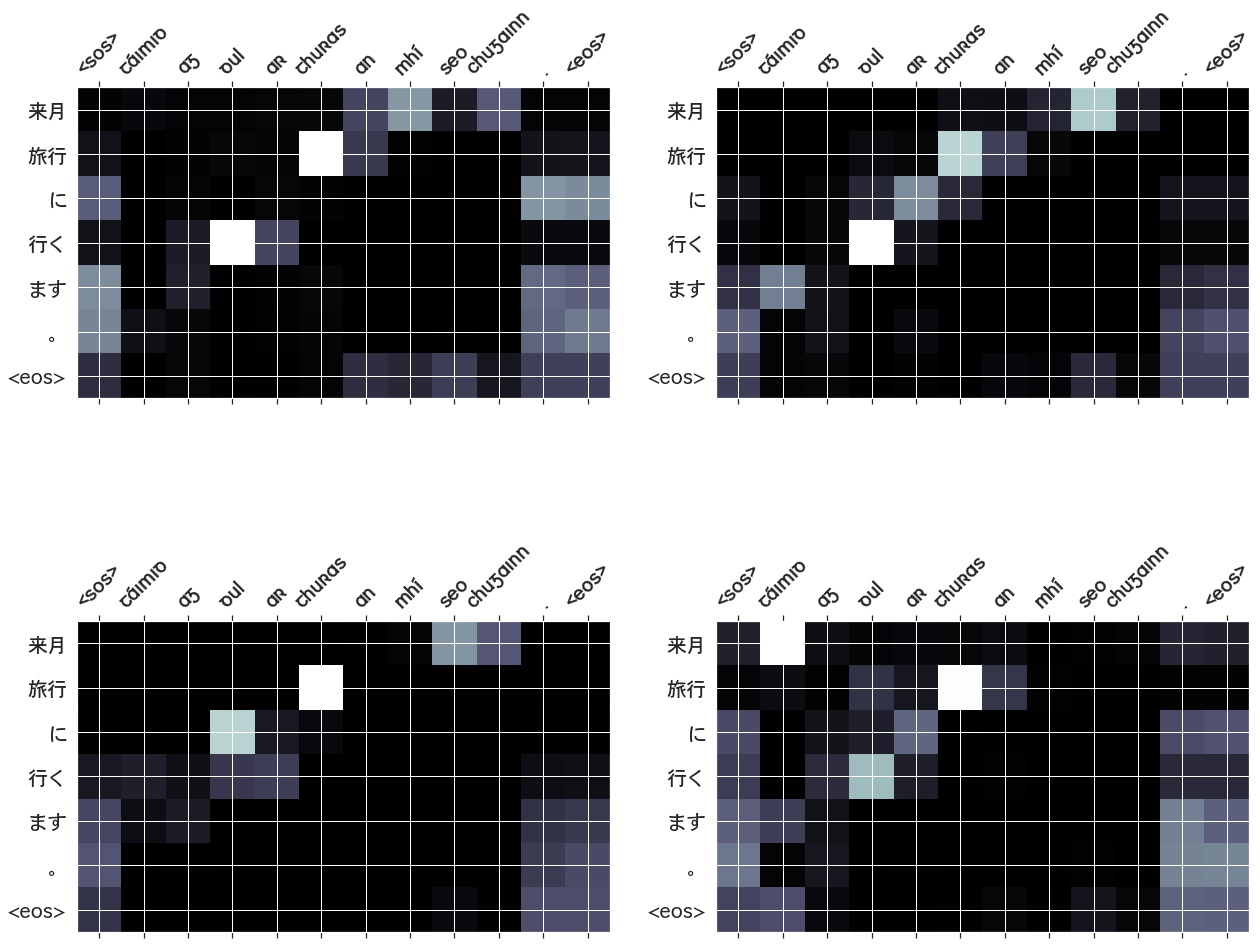

In [45]:
example_idx = random.randint(0, len(valid_data) - 1)

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()

if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

src      : is é seán mo nia .
trg      : ジョン は 私 の 甥 です 。
predicted: ジョン は 私 の おい だ 。 <eos>
     blue: 52.28%


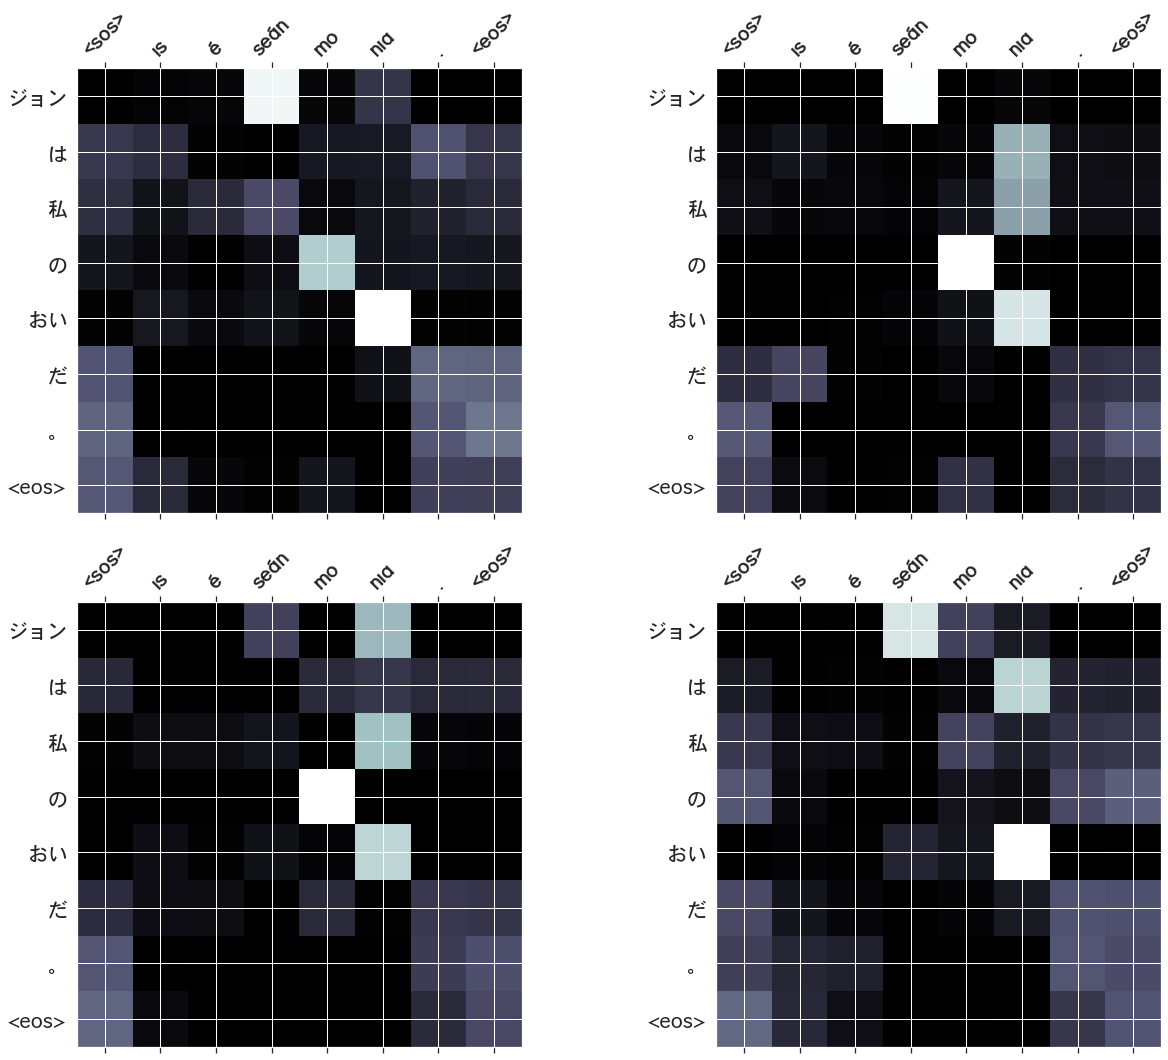

In [46]:
example_idx = random.randint(0, len(test_data) - 1)

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']
translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)

if reverse_src:
    src.reverse()
 
if reverse_trg:
    trg.reverse()
    translation.reverse()

print(f'src      : {" ".join(src)}')
print(f'trg      : {" ".join(trg)}')
print(f'predicted: {" ".join(translation)}')
print(f'     blue: {100 * sentence_blue(trg, translation):.2f}%')
display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

Выведем не более 50 предложений с `BLUE` не менее 0.9

1
src      : d'iarr mé air cabhrú liom .
trg      : 私 は 彼 に 助ける て くれる よう に 頼む だ 。
predicted: 私 は 彼 に 助ける て くれる よう に 頼む だ 。 <eos>
     blue: 100.00%


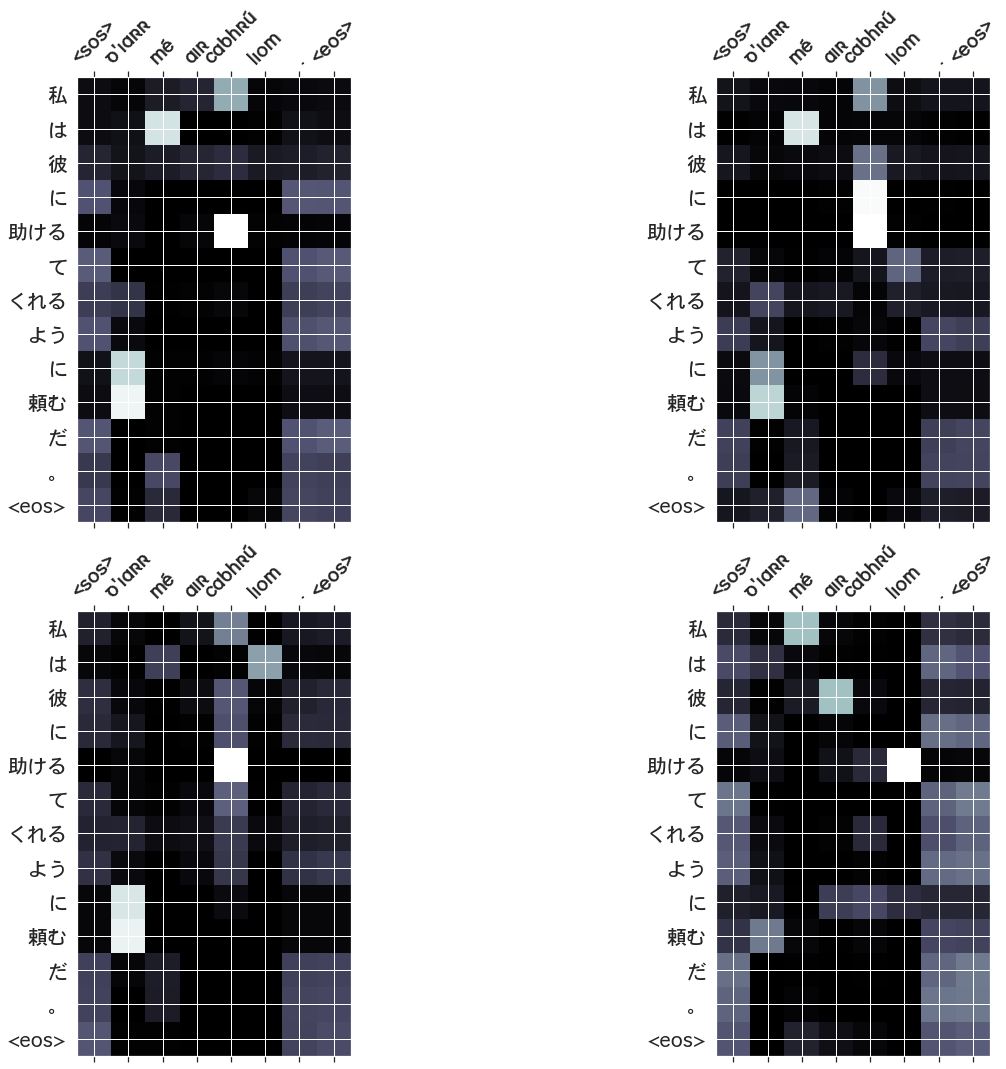

2
src      : tá sí an - bhreá .
trg      : 彼女 は とても かわいい 。
predicted: 彼女 は とても かわいい 。 <eos>
     blue: 100.00%


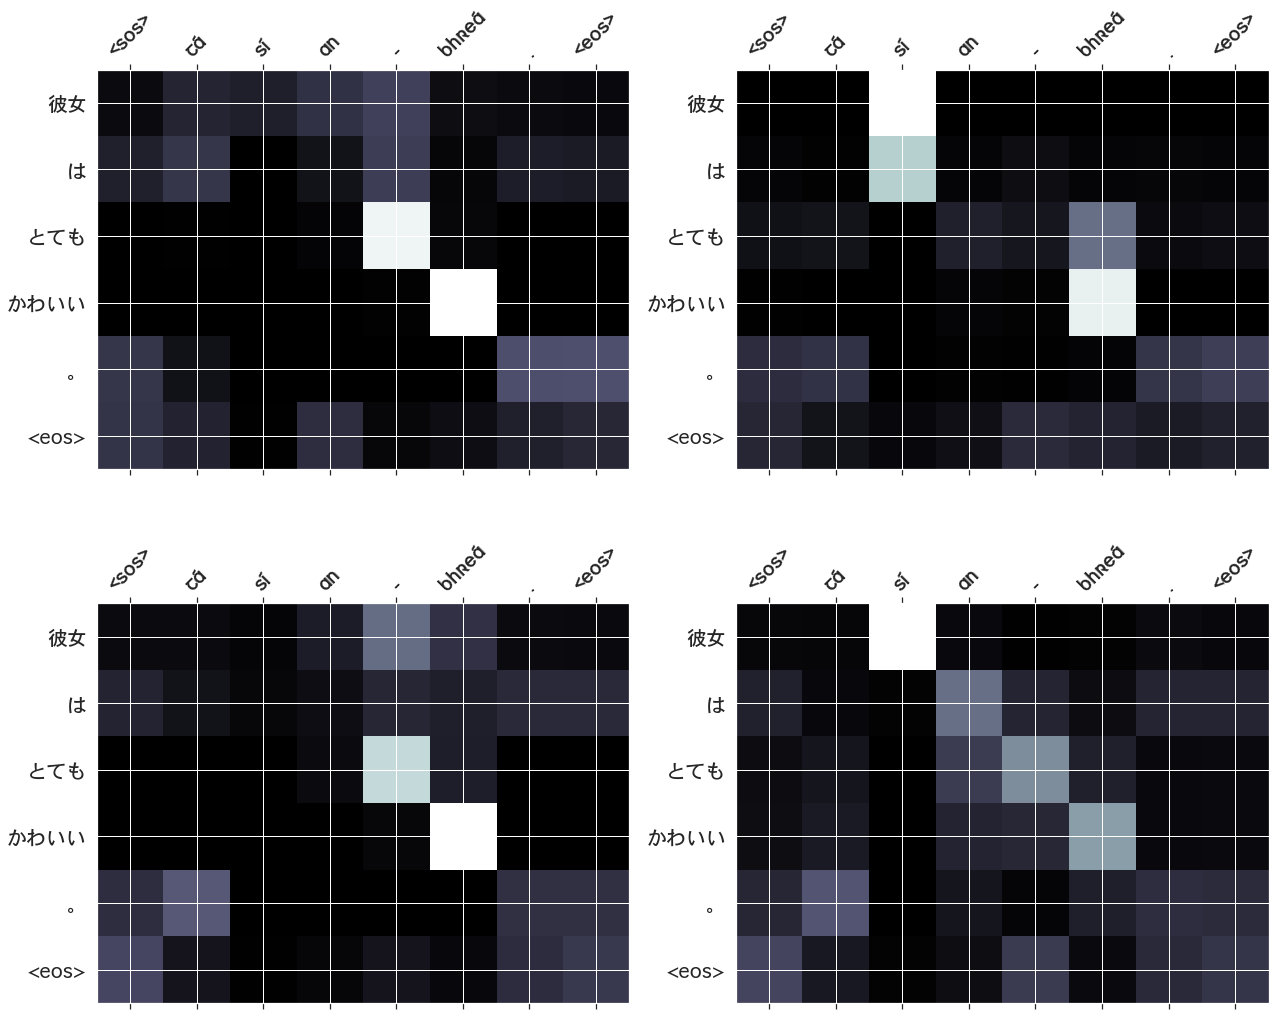

3
src      : níl an scoil ach cúig nóiméad siúil as seo .
trg      : 学校 は ここ から 歩く て ５ 分 です 。
predicted: 学校 は ここ から 歩く て ５ 分 です 。 <eos>
     blue: 100.00%


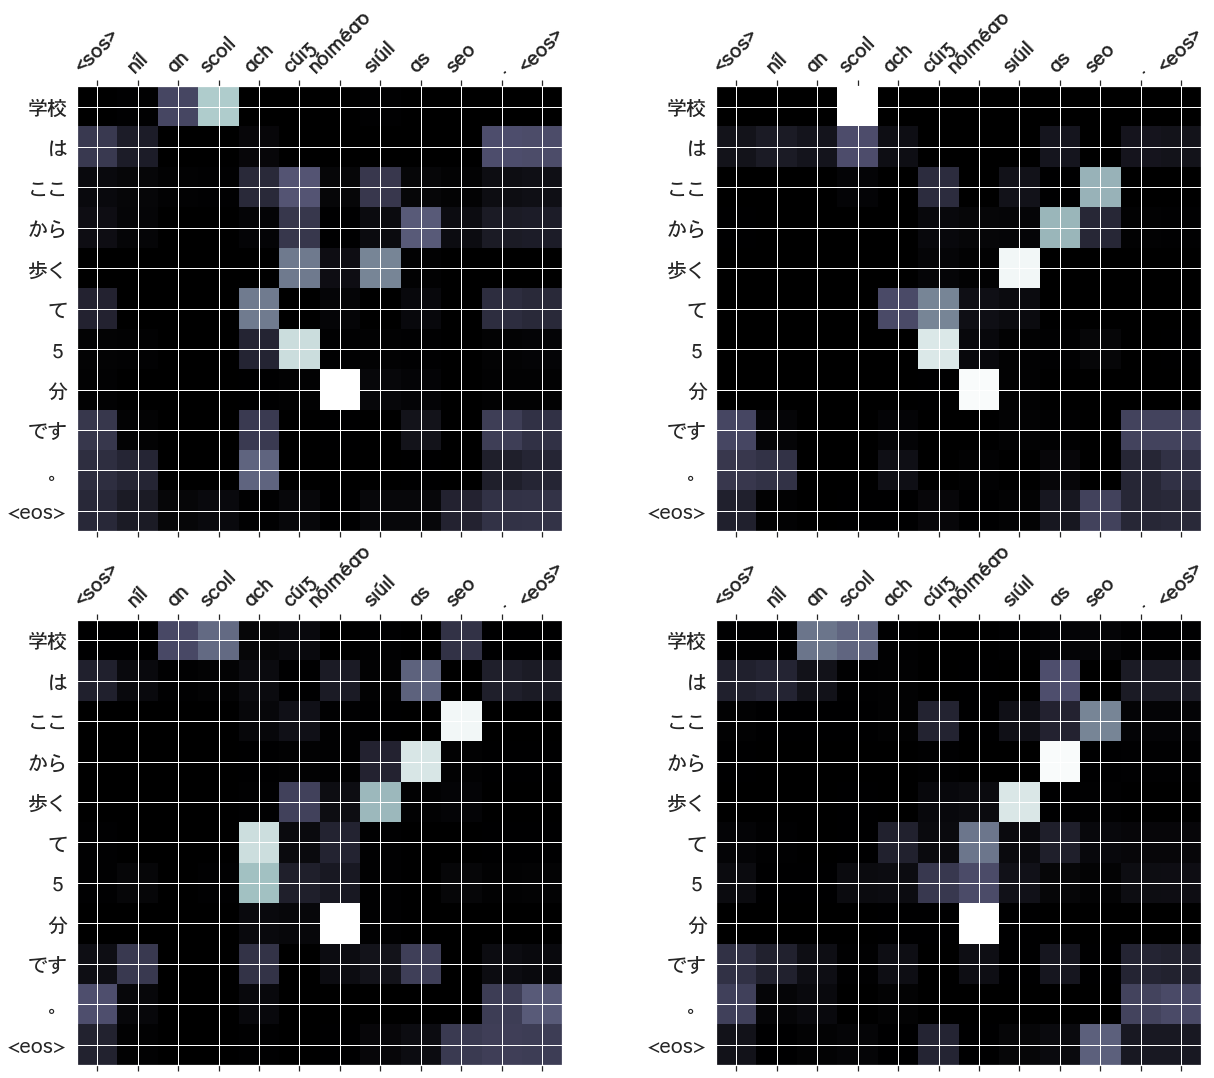

4
src      : caithfidh tú cuntas a thabhairt ar an toradh .
trg      : 君 は その 結果 を 説明 する ない ば なる ない 。
predicted: 君 は その 結果 を 説明 する ない ば なる ない 。 <eos>
     blue: 100.00%


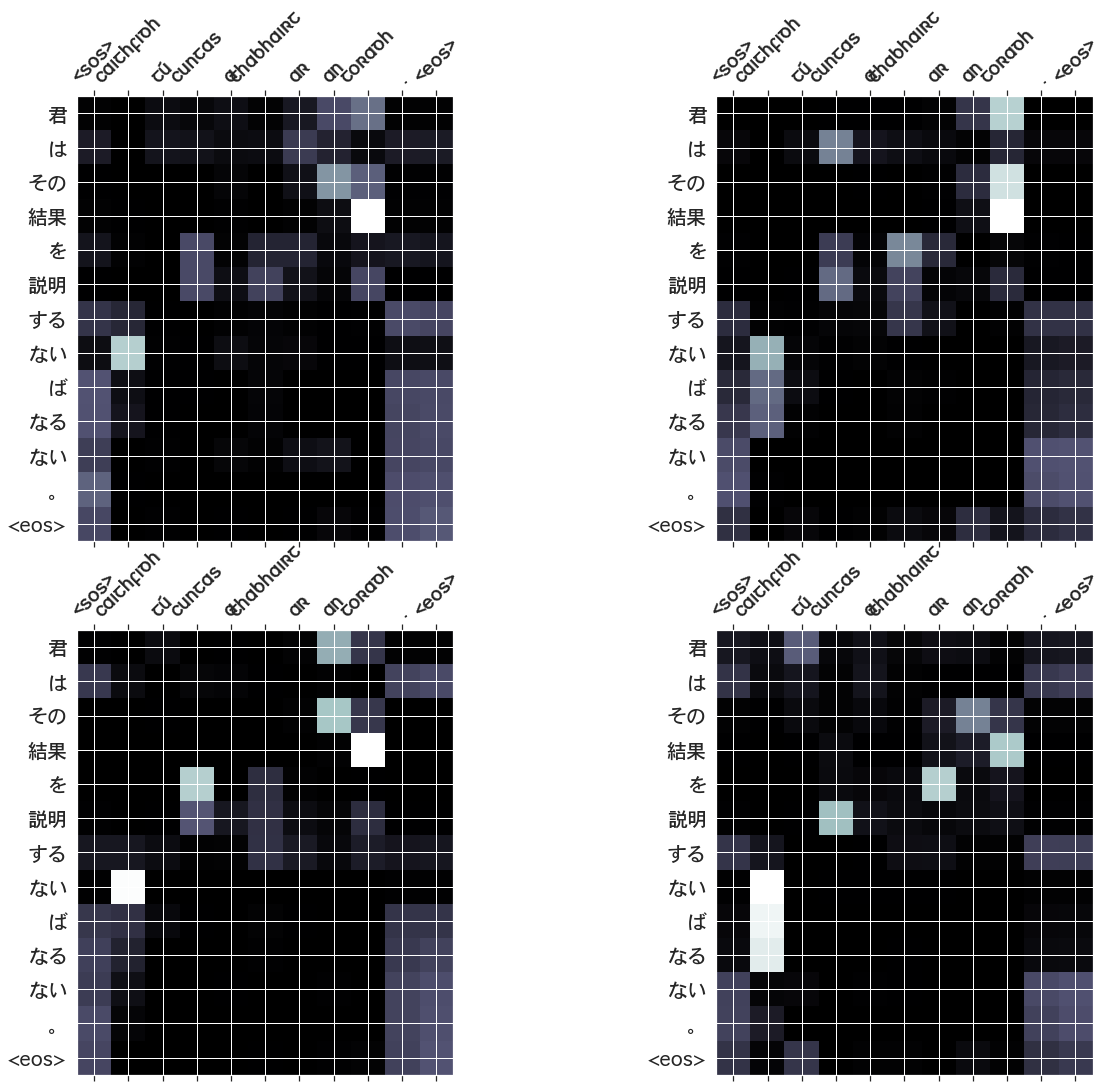

5
src      : conas a thaitin an cóisir leat ?
trg      : パーティー は いかが です た か 。
predicted: パーティー は いかが です た か 。 <eos>
     blue: 100.00%


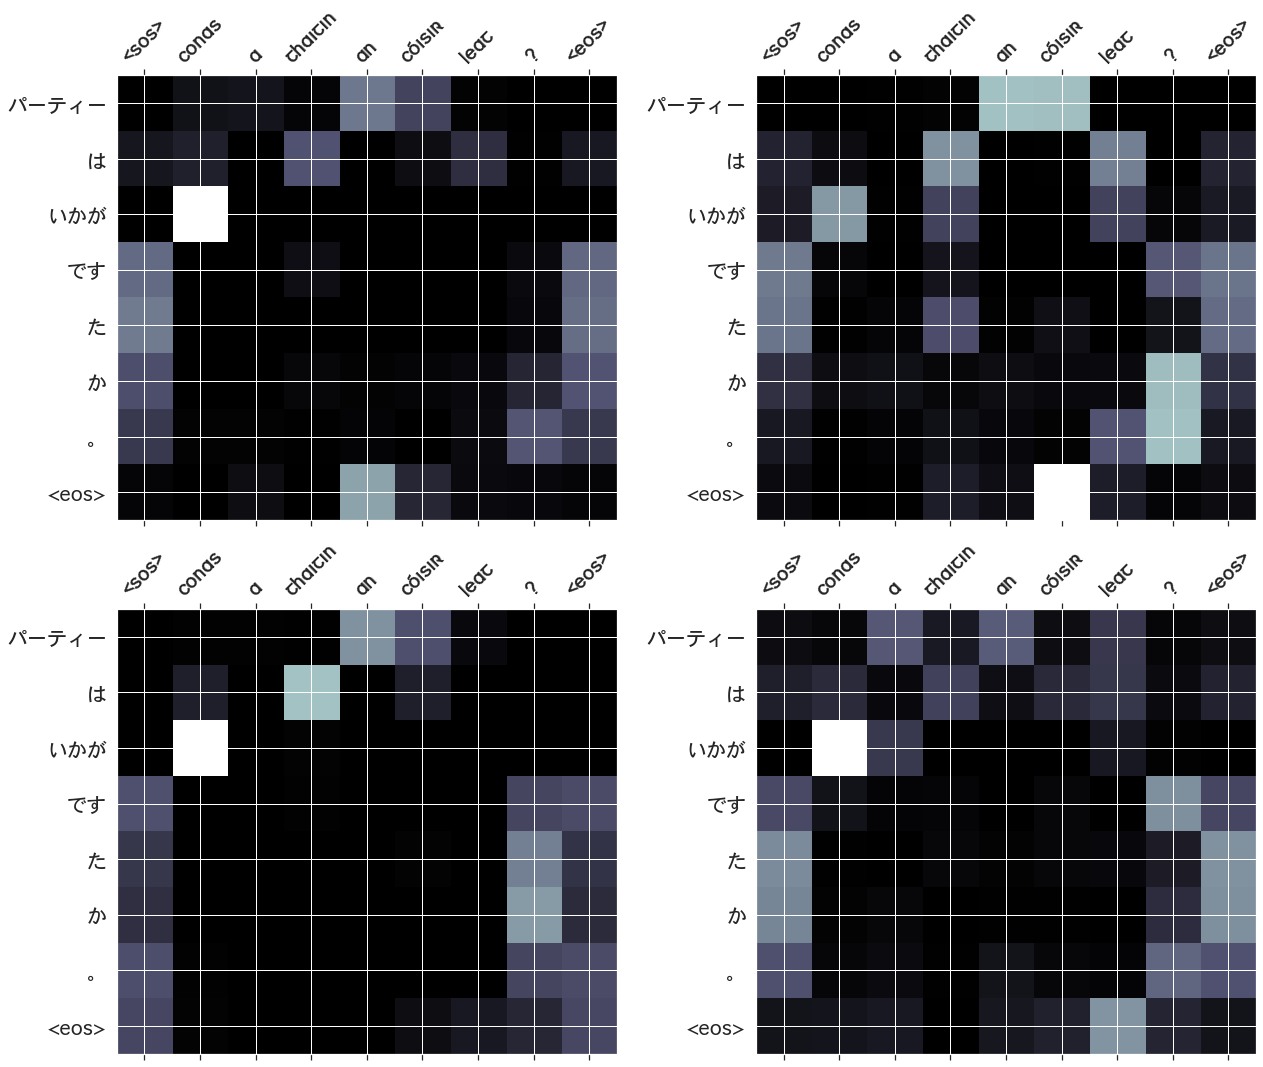

6
src      : bhí sé ag iompú go dícheallach ar leathanaigh irisleabhair .
trg      : 彼 は ぼんやり と 雑誌 の ページ を めくる て いる た 。
predicted: 彼 は ぼんやり と 雑誌 の ページ を めくる て いる た 。 <eos>
     blue: 100.00%


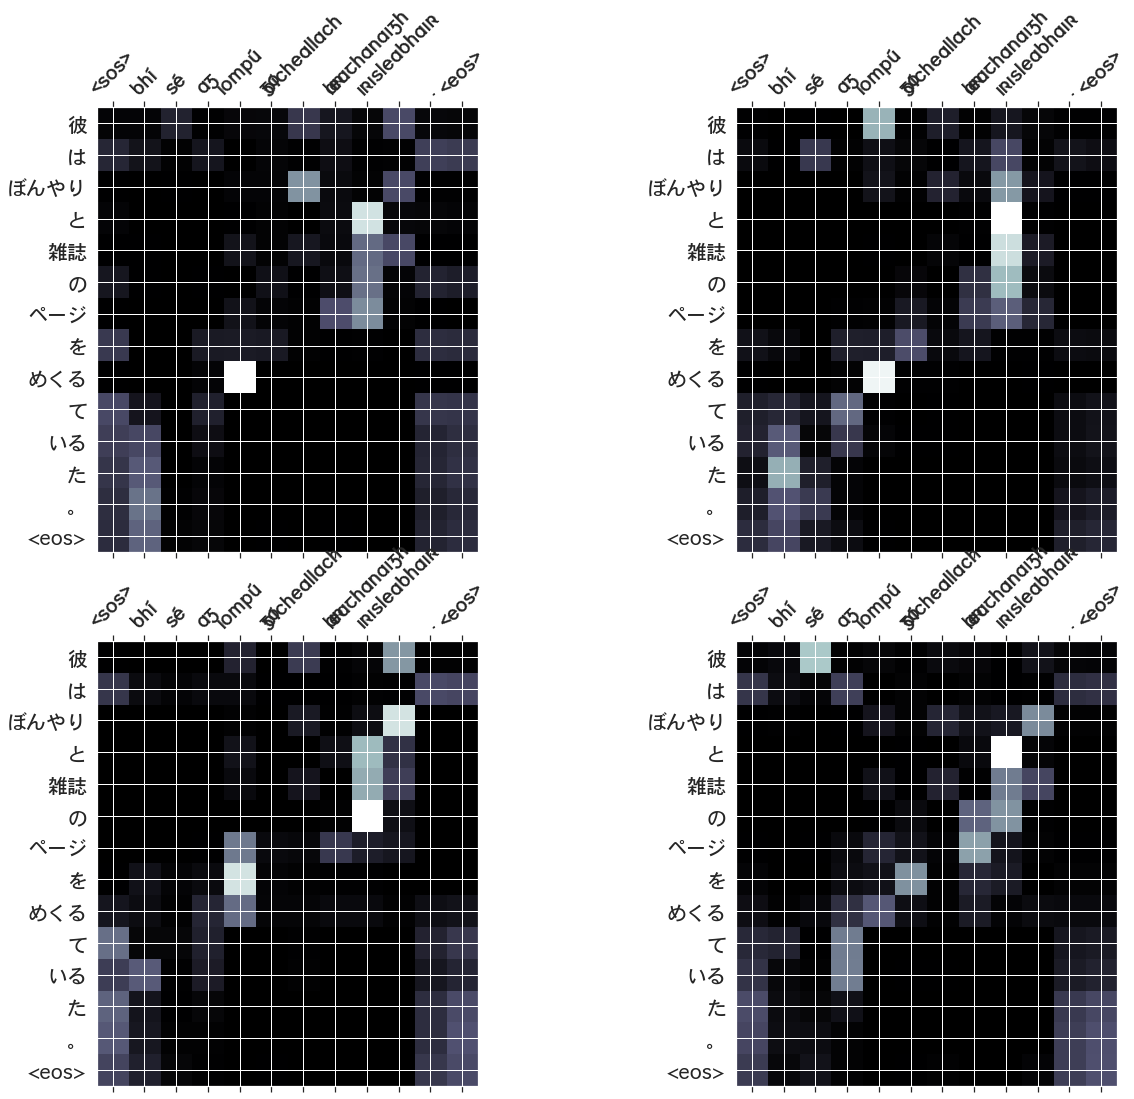

7
src      : tá cónaí orainn i gcomharsanacht na scoile .
trg      : 私 たち は 学校 の 近く に 住む で いる 。
predicted: 私 たち は 学校 の 近く に 住む で いる 。 <eos>
     blue: 100.00%


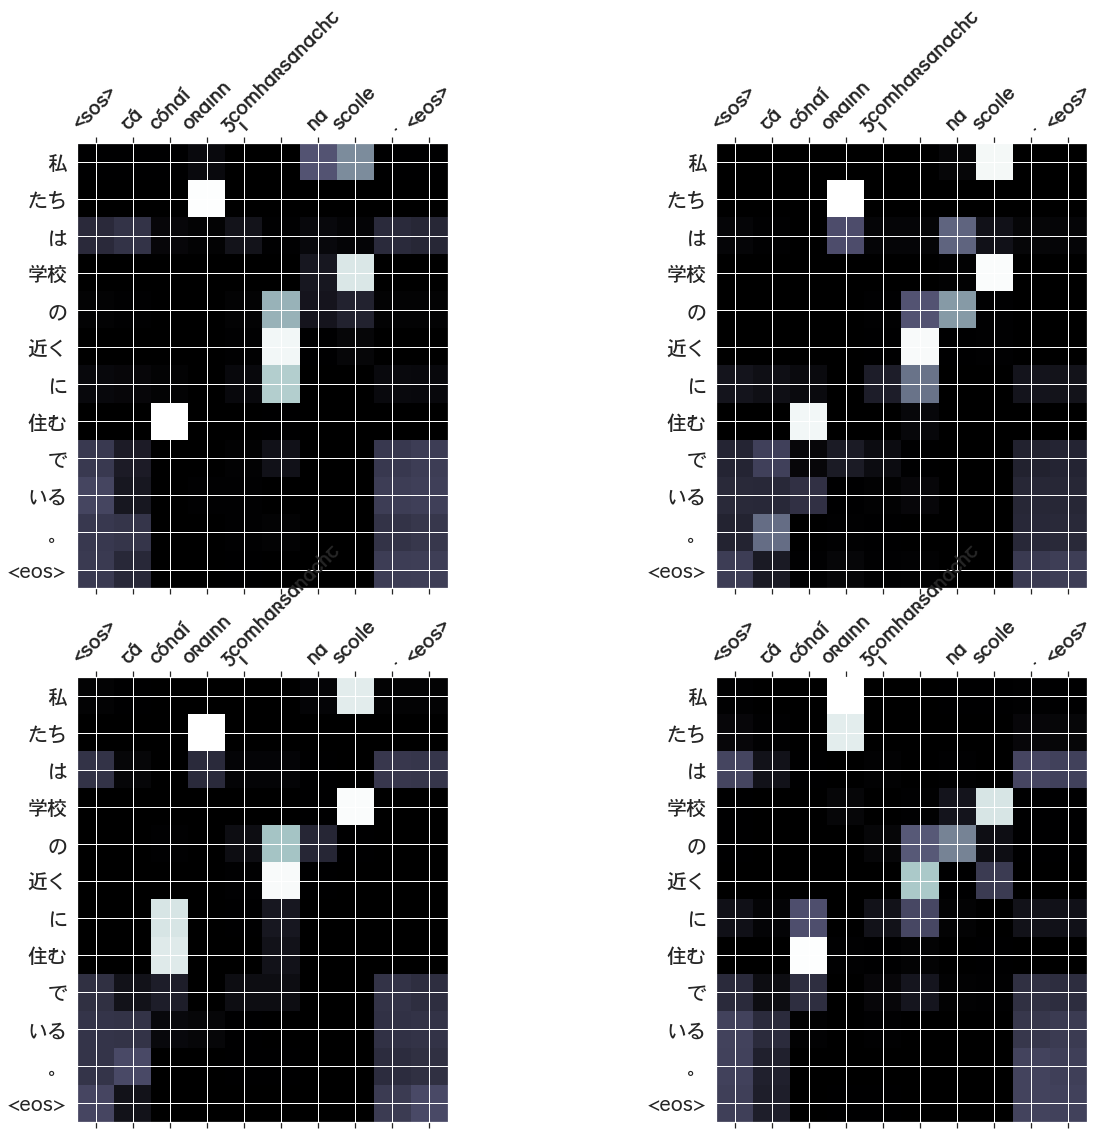

8
src      : bhí siad ag éisteacht leis an raidió .
trg      : 彼ら は ラジオ を 聞く て いる た 。
predicted: 彼ら は ラジオ を 聞く て いる た 。 <eos>
     blue: 100.00%


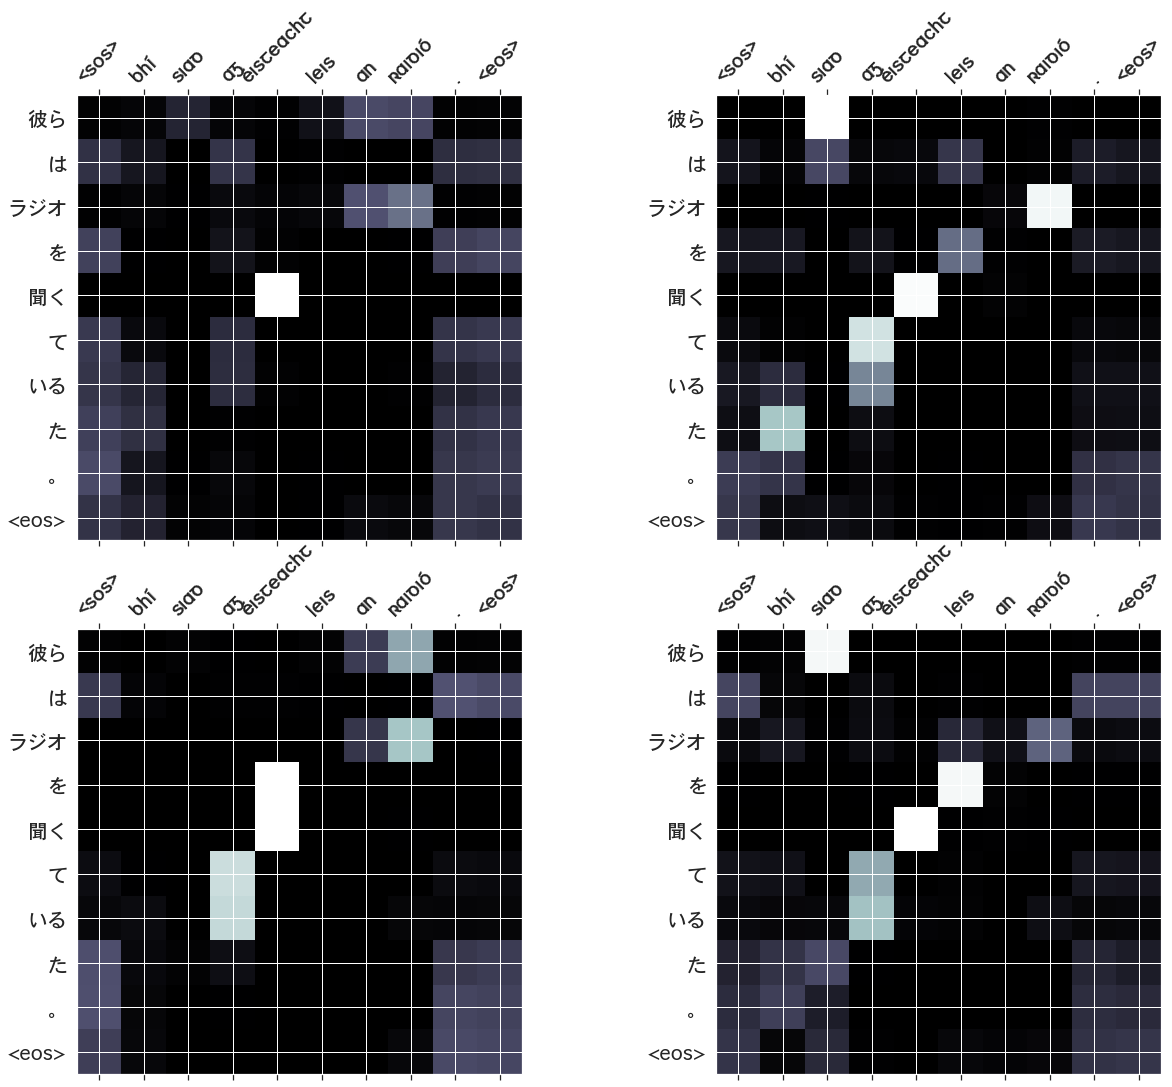

9
src      : tá réaltaí neamhiomlána sa chruinne .
trg      : 宇宙 に は 無数 の 星 が ある 。
predicted: 宇宙 に は 無数 の 星 が ある 。 <eos>
     blue: 100.00%


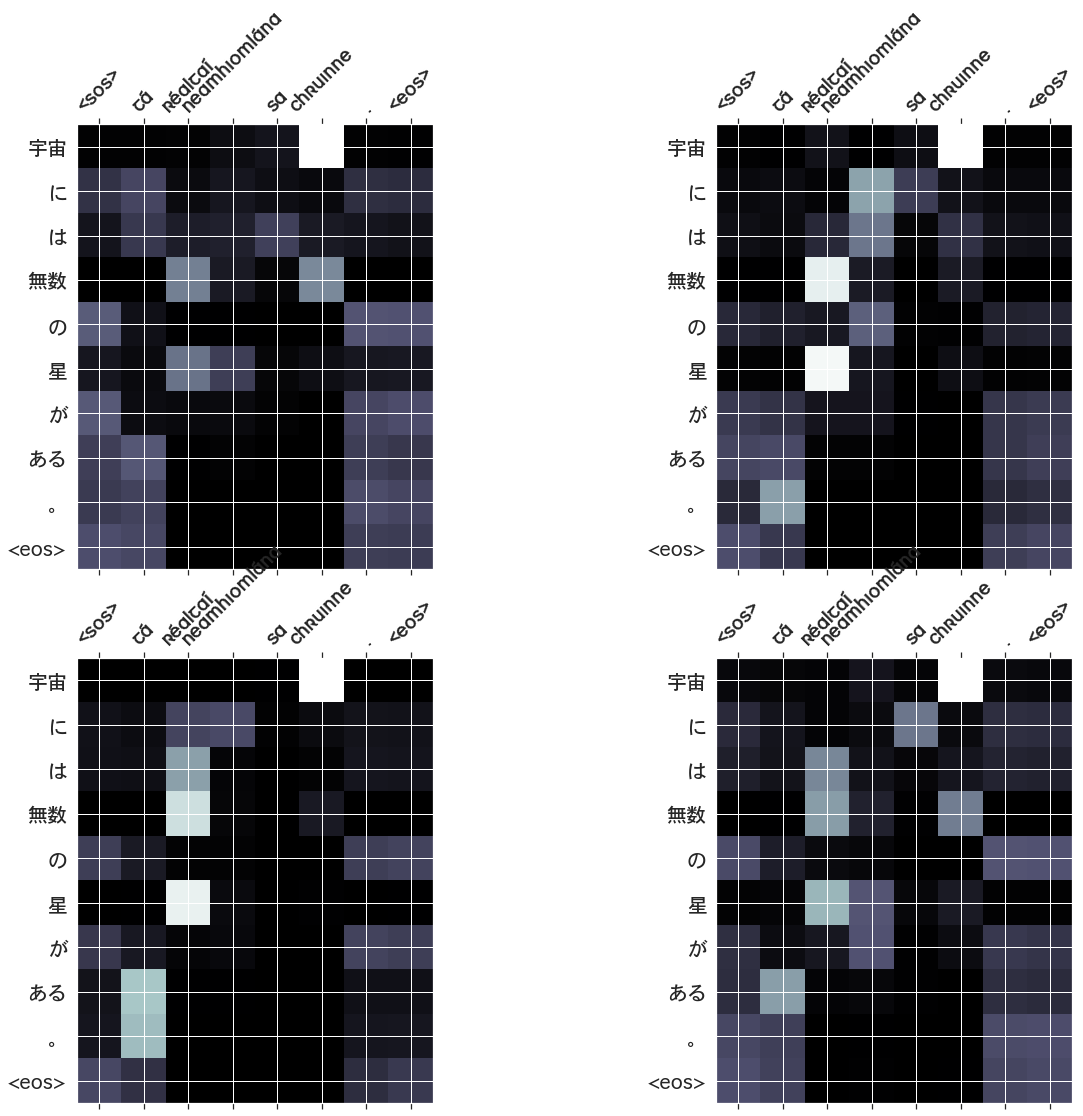

10
src      : caithfidh mé imeacht go luath amárach .
trg      : 私 は 明日 早い 出発 する ない ば なる ない 。
predicted: 私 は 明日 早い 出発 する ない ば なる ない 。 <eos>
     blue: 100.00%


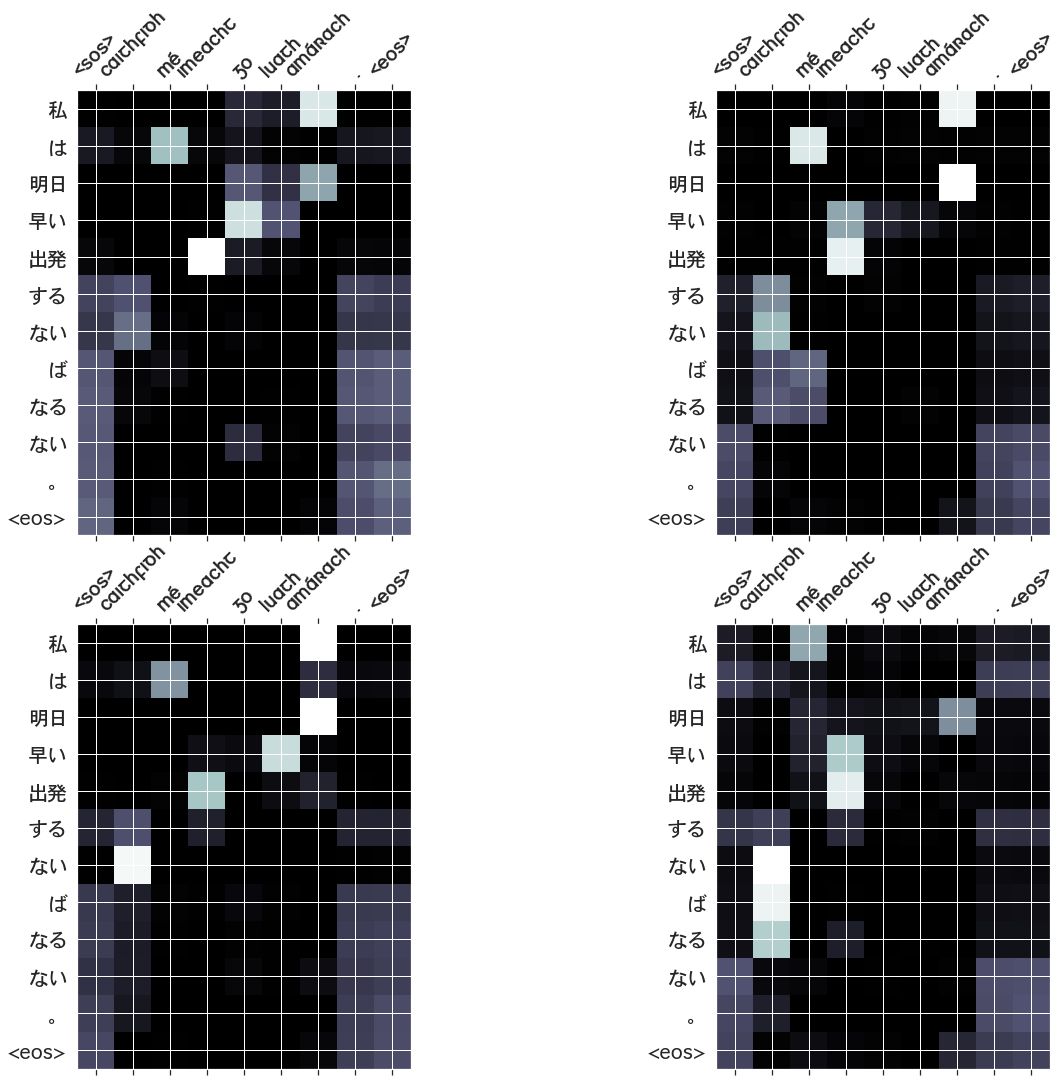

11
src      : níl an leabhar seo chomh mór leis an leabhar sin .
trg      : この 本 は あの 本 ほど 大きい ない 。
predicted: この 本 は あの 本 ほど 大きい ない 。 <eos>
     blue: 100.00%


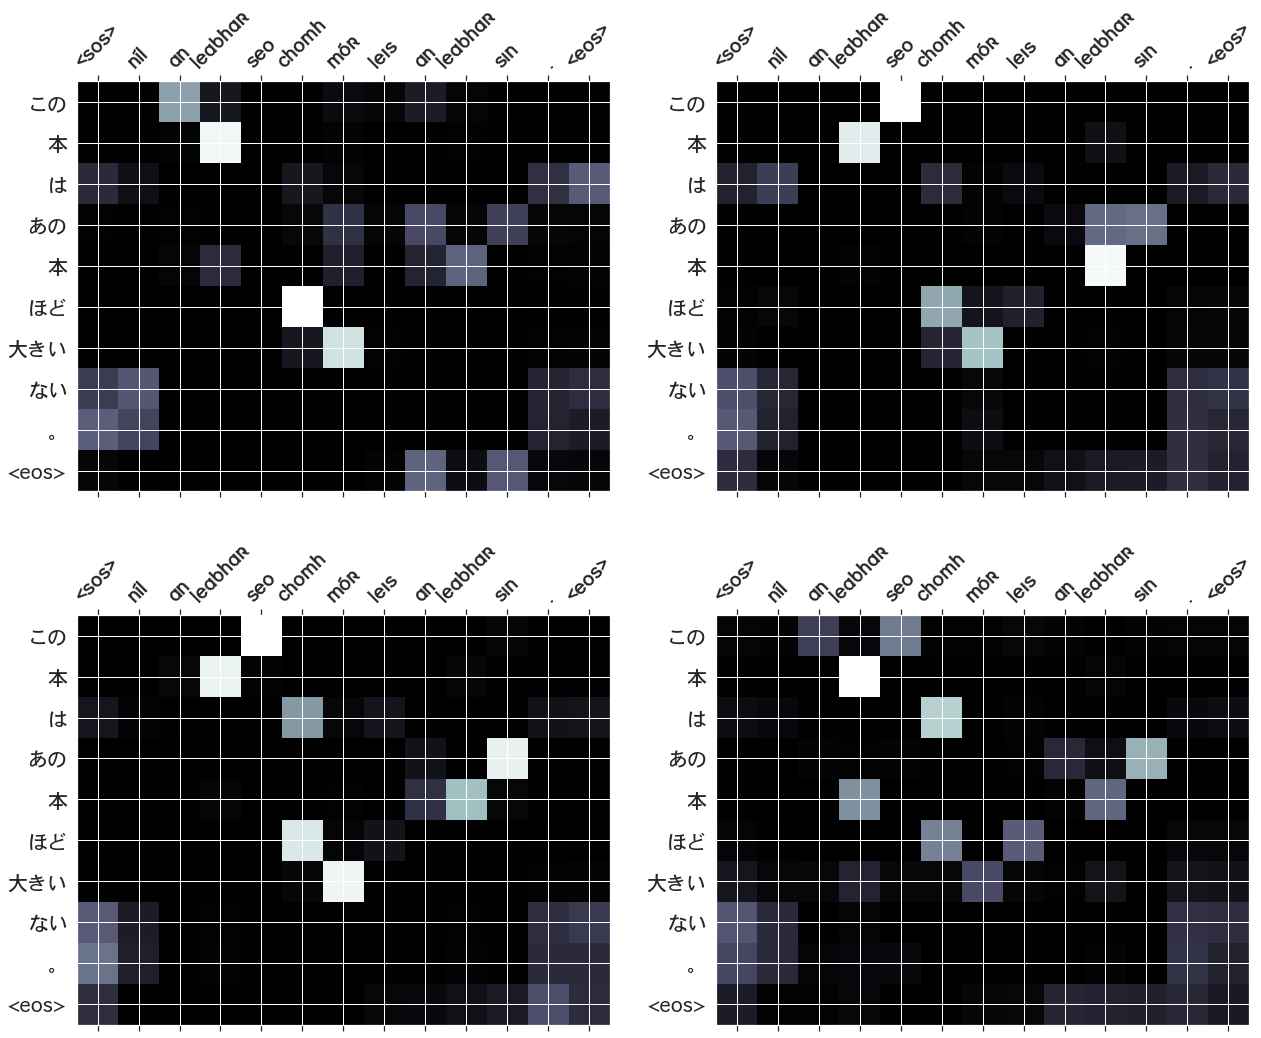

12
src      : b’fhéidir gur léigh sé an litir .
trg      : 彼 は その 手紙 を 読む だ かも しれる ない 。
predicted: 彼 は その 手紙 を 読む だ かも しれる ない 。 <eos>
     blue: 100.00%


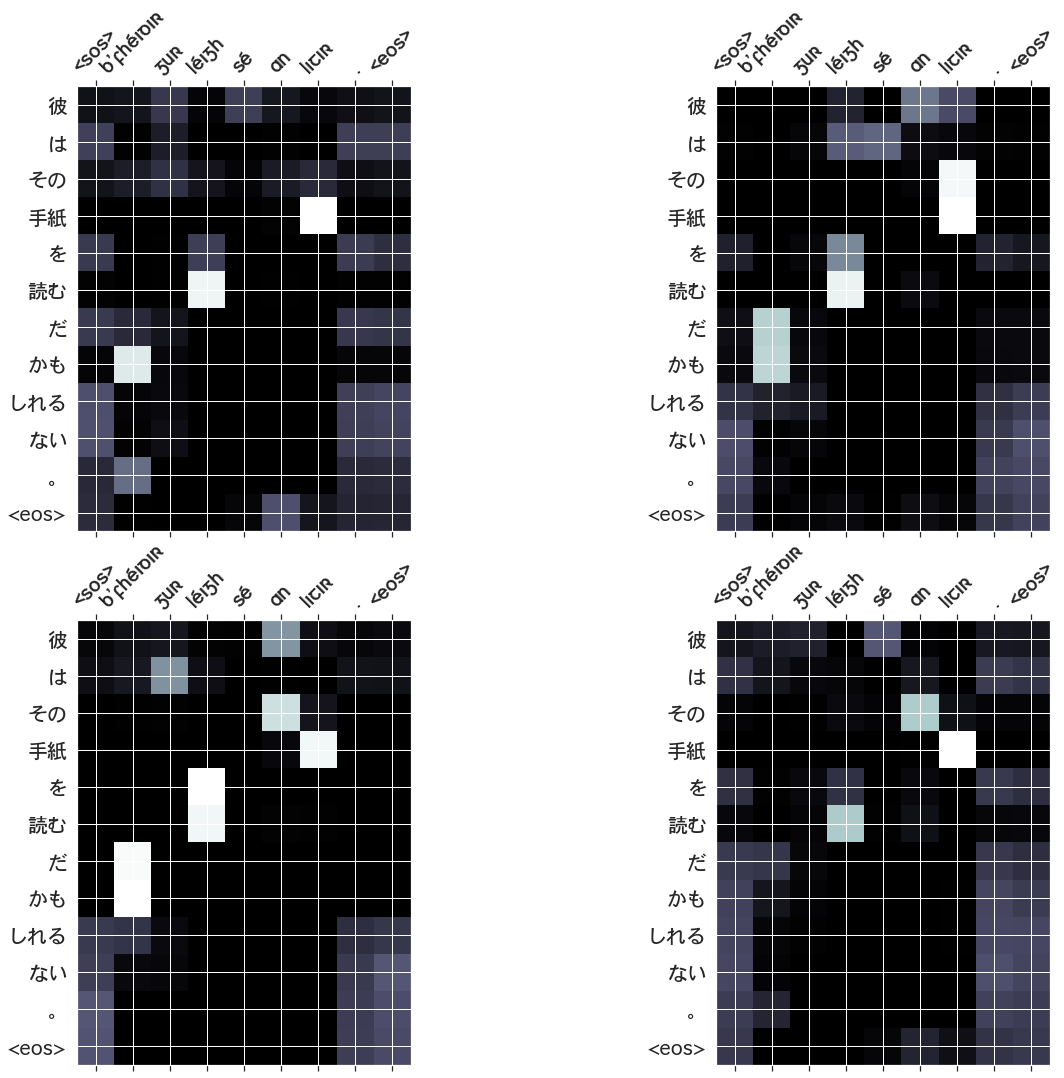

13
src      : ar mhaith leat an iris seo a léamh ?
trg      : この 雑誌 を 読む たい です か 。
predicted: この 雑誌 を 読む たい です か 。 <eos>
     blue: 100.00%


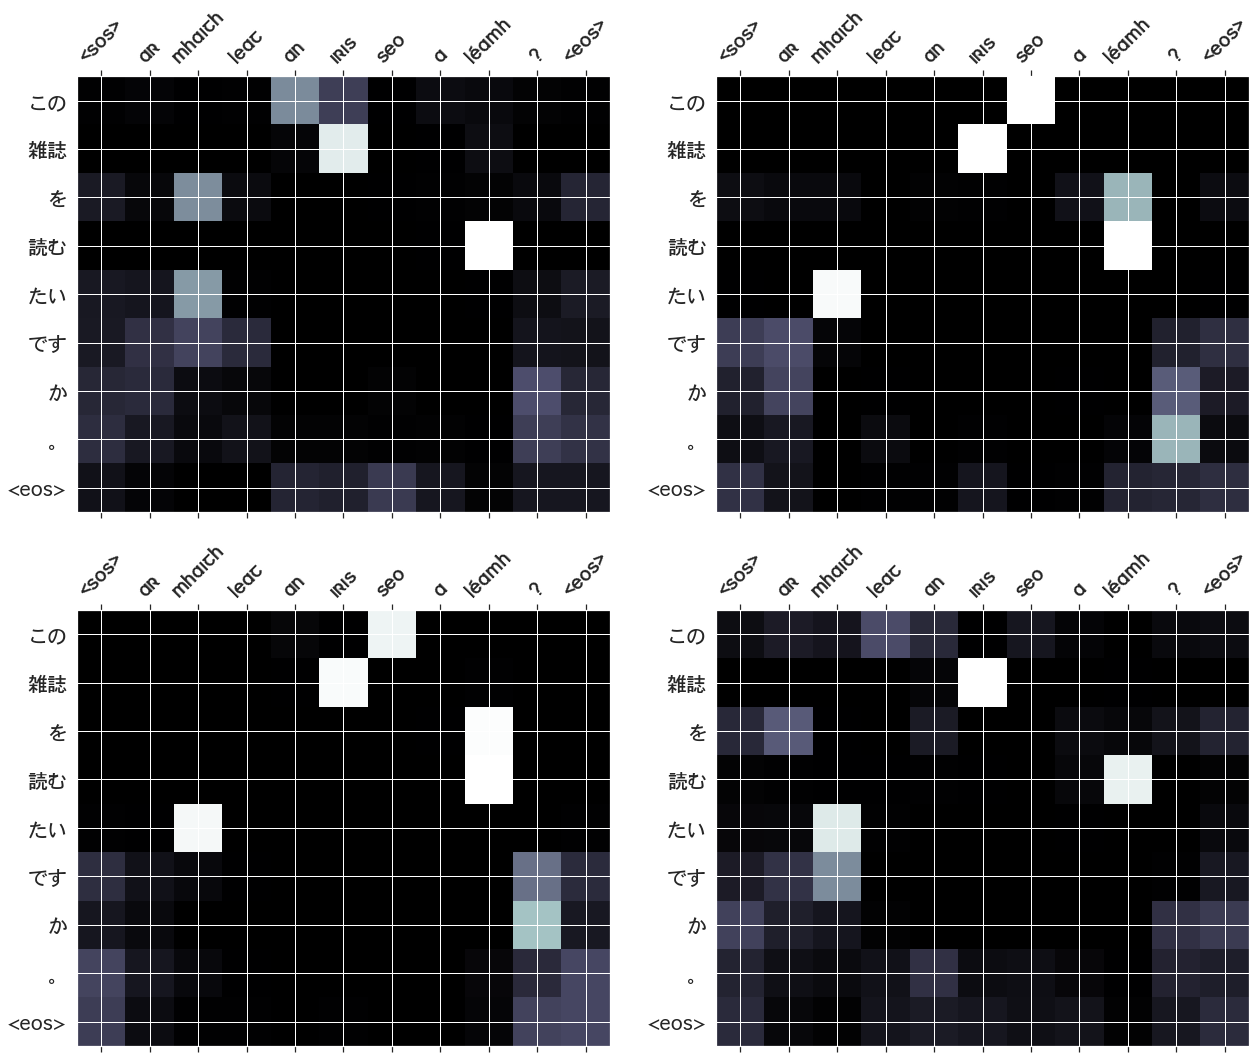

14
src      : mhéadaigh an tiománaí a luas .
trg      : 運転 手 は スピード を 上げる た 。
predicted: 運転 手 は スピード を 上げる た 。 <eos>
     blue: 100.00%


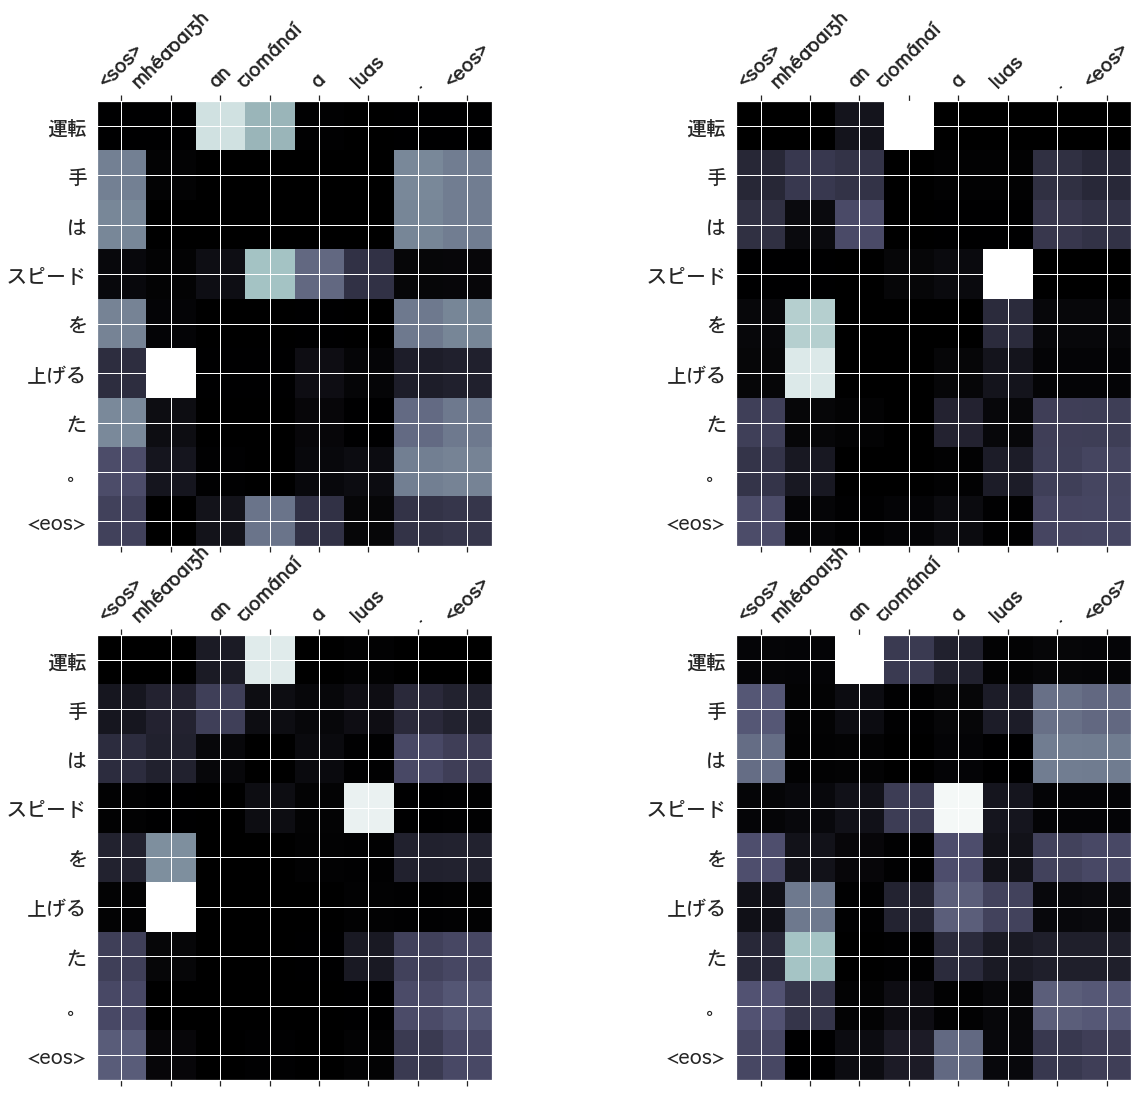

15
src      : cuir bindealán i bhfeidhm .
trg      : 包帯 を する なさる 。
predicted: 包帯 を する なさる 。 <eos>
     blue: 100.00%


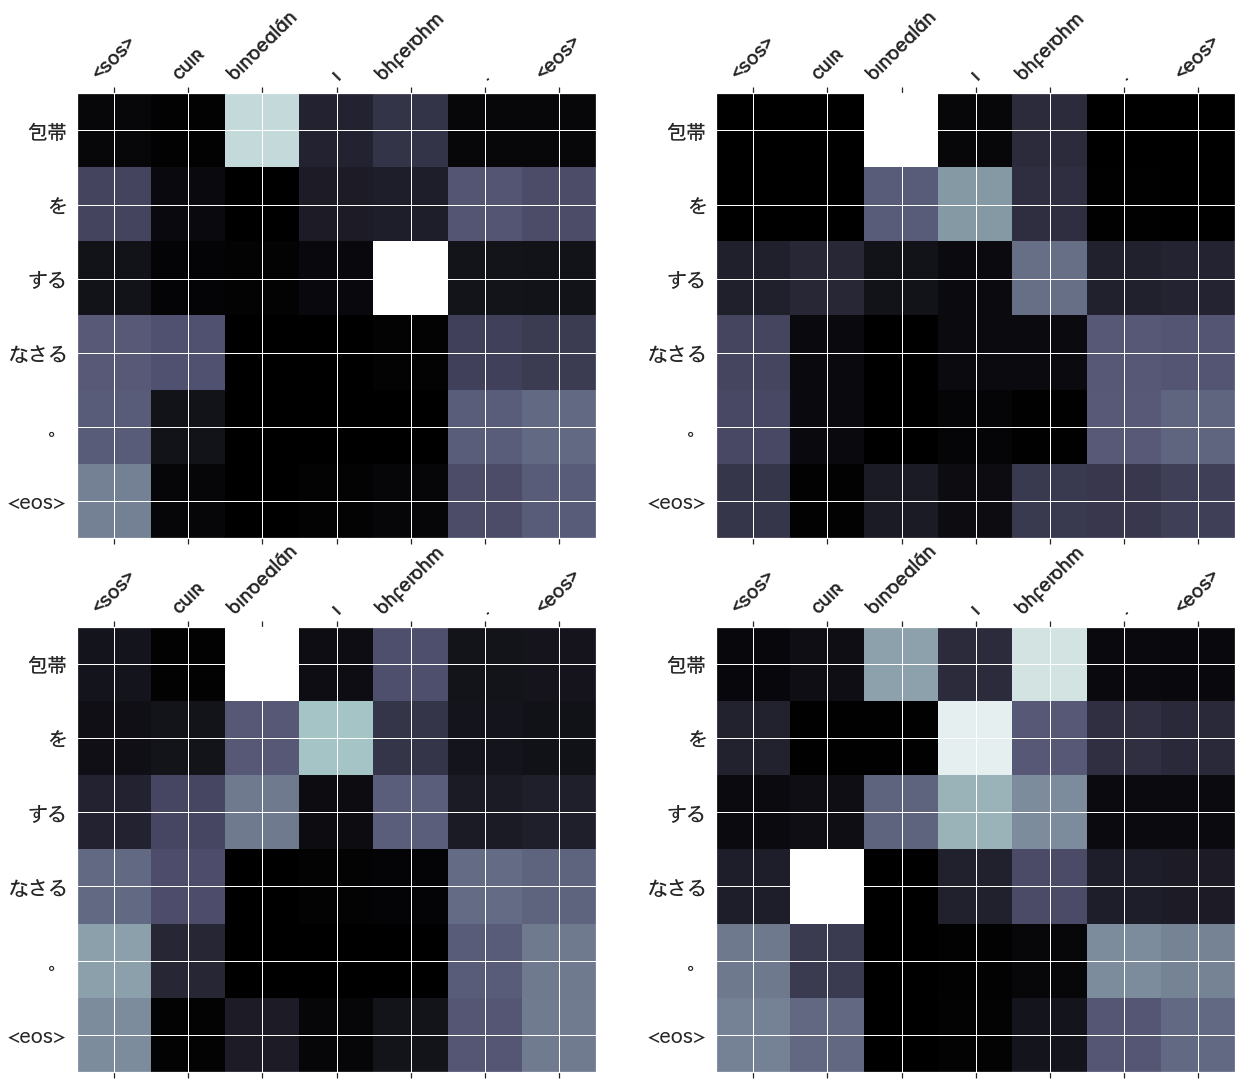

16
src      : caithfidh mé leithscéal a ghabháil léi .
trg      : 私 は 彼女 に 謝る ない ば なる ない 。
predicted: 私 は 彼女 に 謝る ない ば なる ない 。 <eos>
     blue: 100.00%


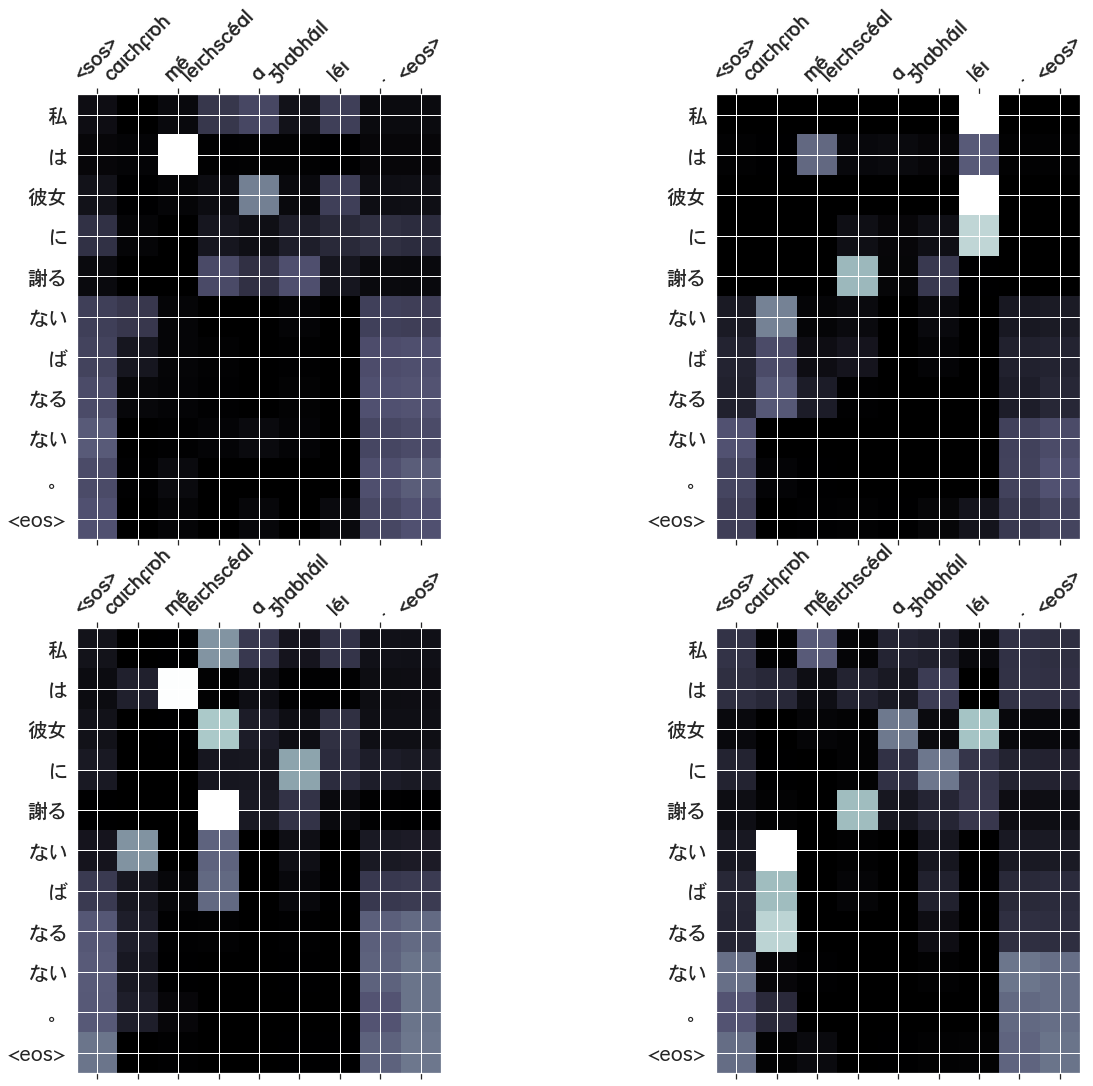

17
src      : tá na bróga seo ró - dhaingean .
trg      : この 靴 は きつい すぎる 。
predicted: この 靴 は きつい すぎる 。 <eos>
     blue: 100.00%


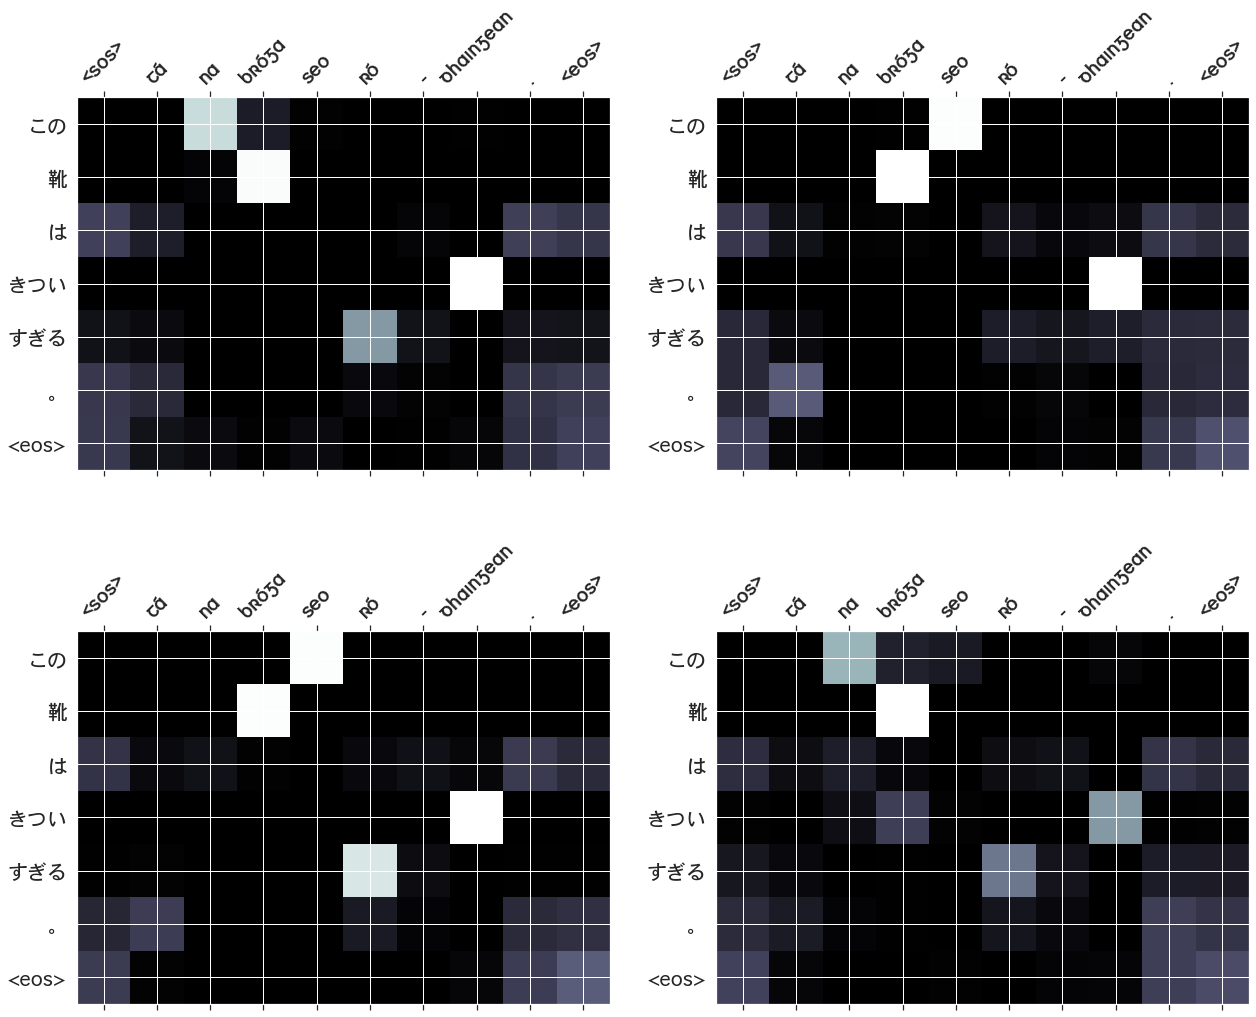

18
src      : bhuail máire ar smaoineamh iontach .
trg      : メアリー は すばらしい 考え を 思いつく た 。
predicted: メアリー は すばらしい 考え を 思いつく た 。 <eos>
     blue: 100.00%


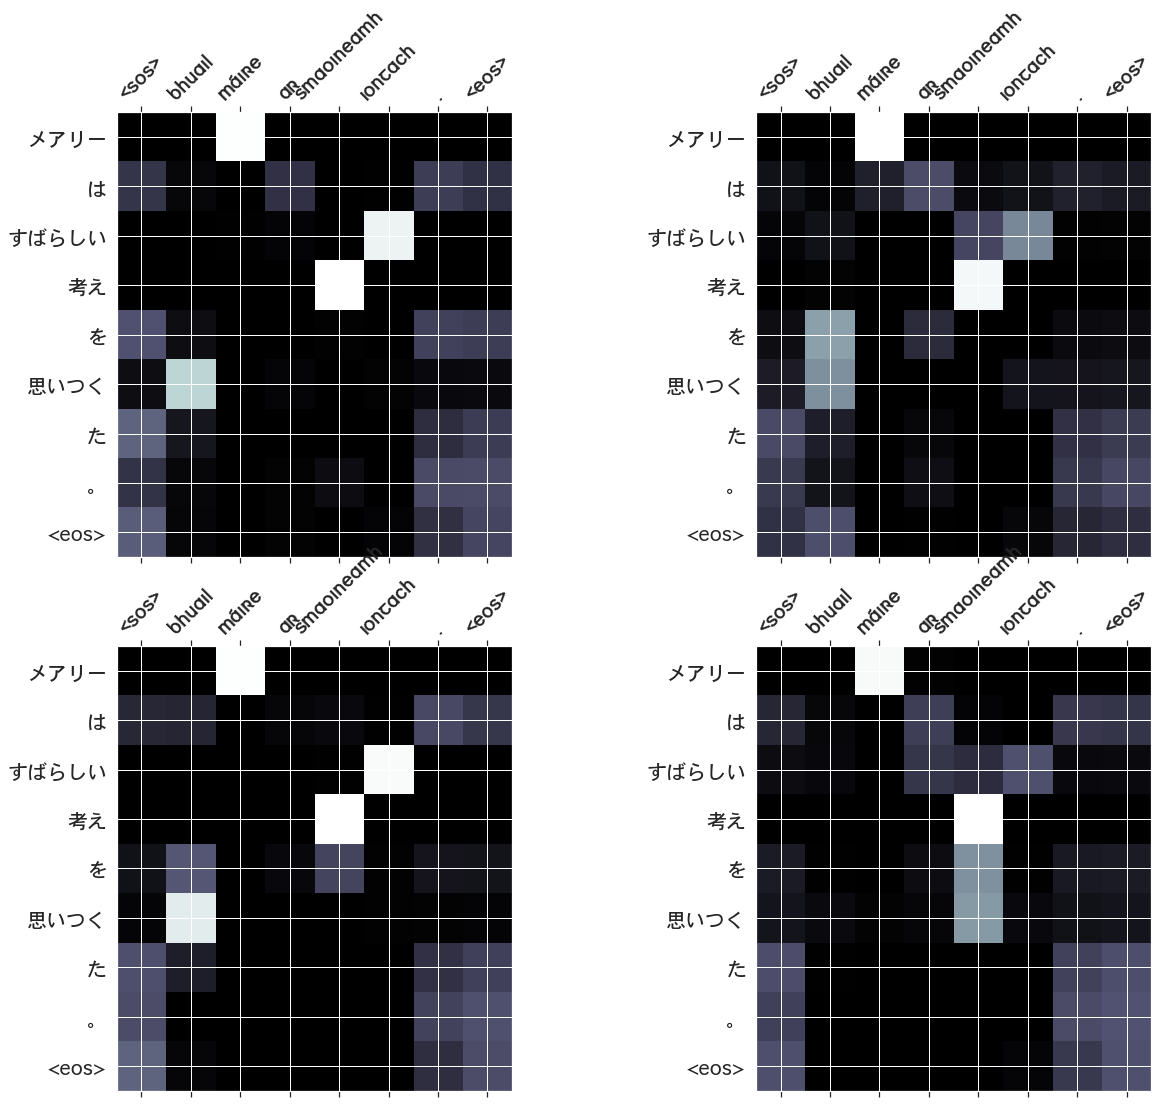

19
src      : tá sí cleachtaithe le suí .
trg      : 彼女 は 座る こと に 慣れる て いる 。
predicted: 彼女 は 座る こと に 慣れる て いる 。 <eos>
     blue: 100.00%


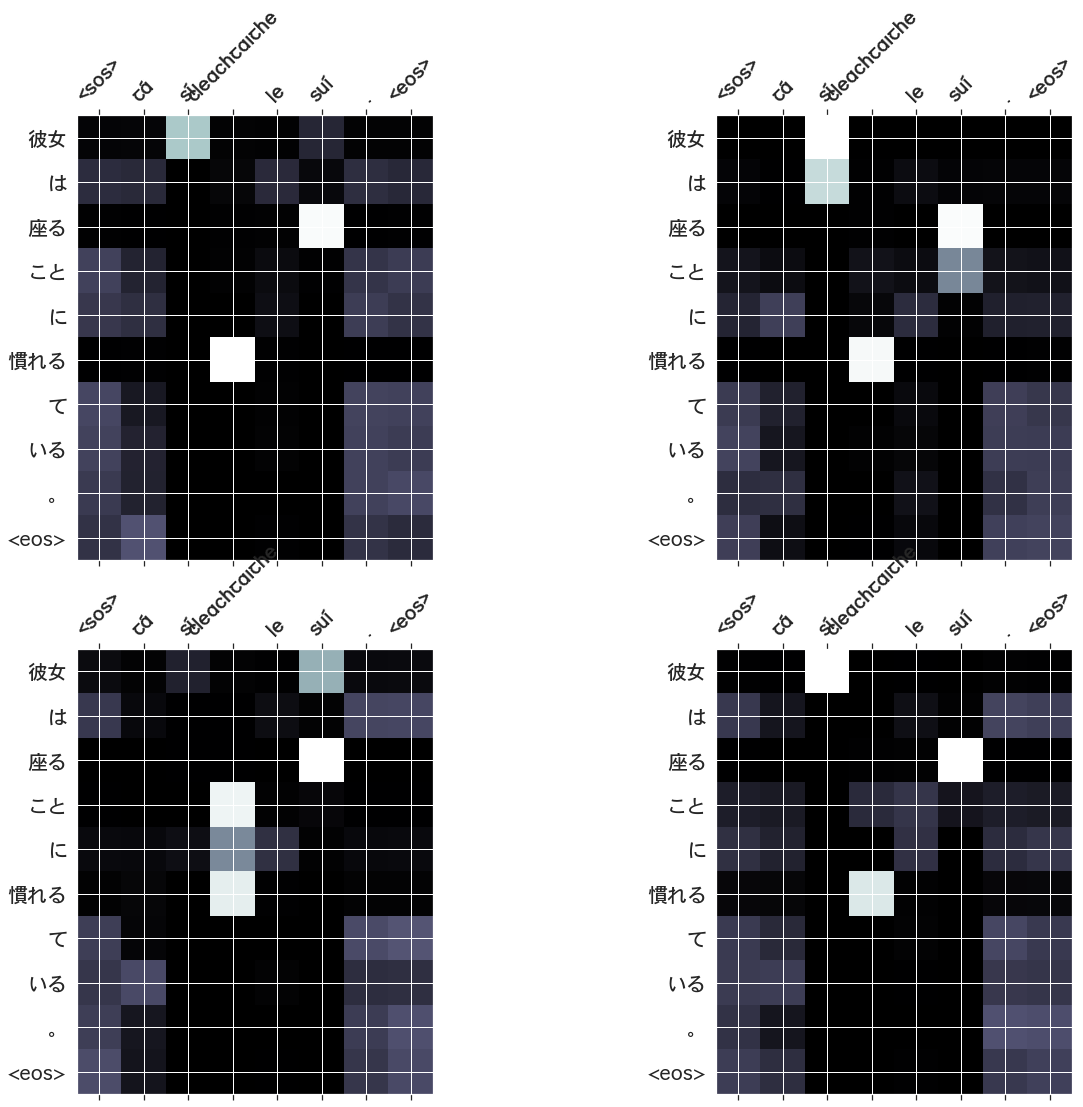

20
src      : dia duit , a bhille . conas tá tú ?
trg      : やあ 、 ビル 。 元気 ？
predicted: やあ ビル 、 どう だい 。 <eos>
     blue: 90.36%


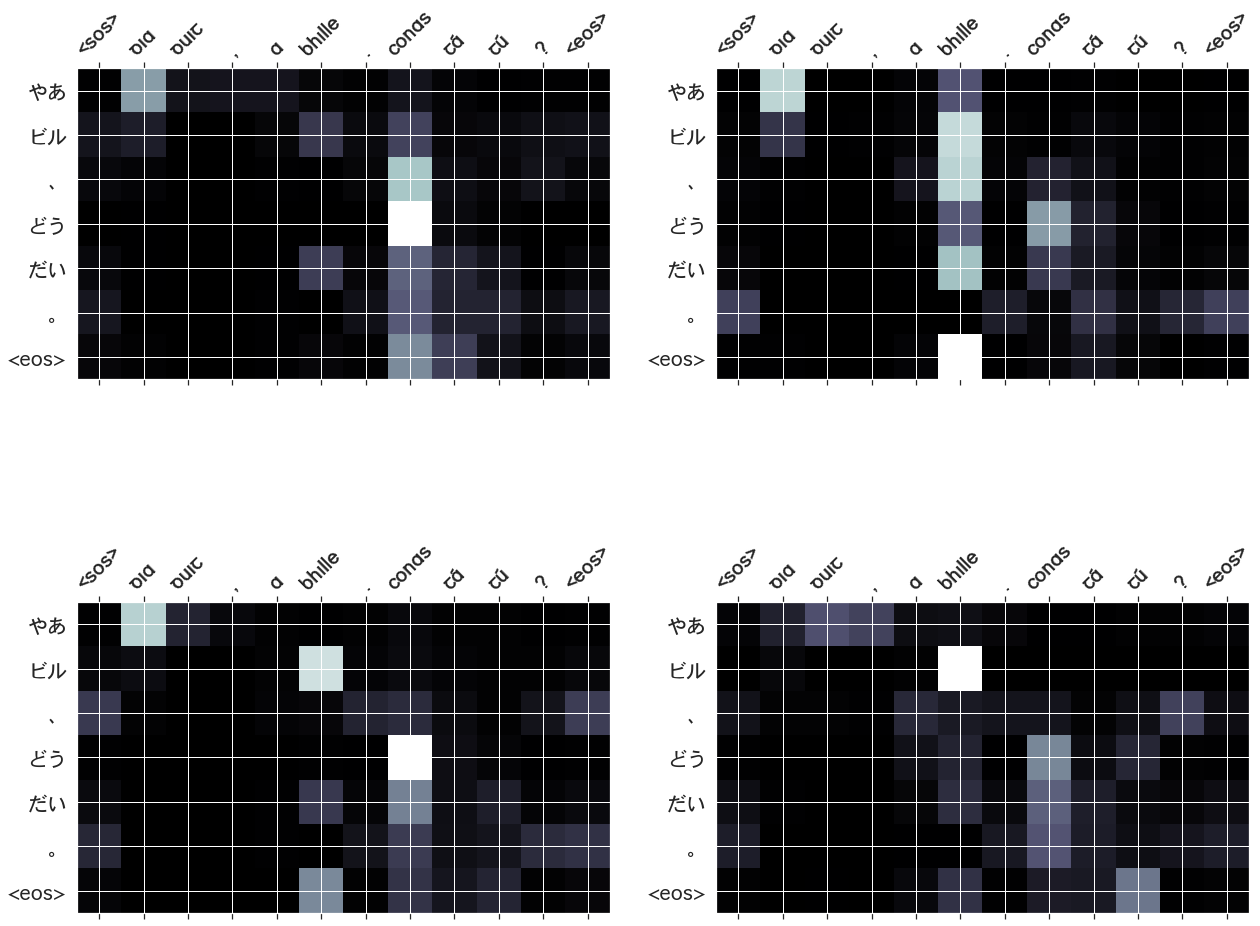

21
src      : an raibh tú i do chónaí i sasayama anuraidh ?
trg      : あなた は 去年 篠山 に 住む で いる ます た か 。
predicted: あなた は 去年 篠山 に 住む で いる ます た か 。 <eos>
     blue: 100.00%


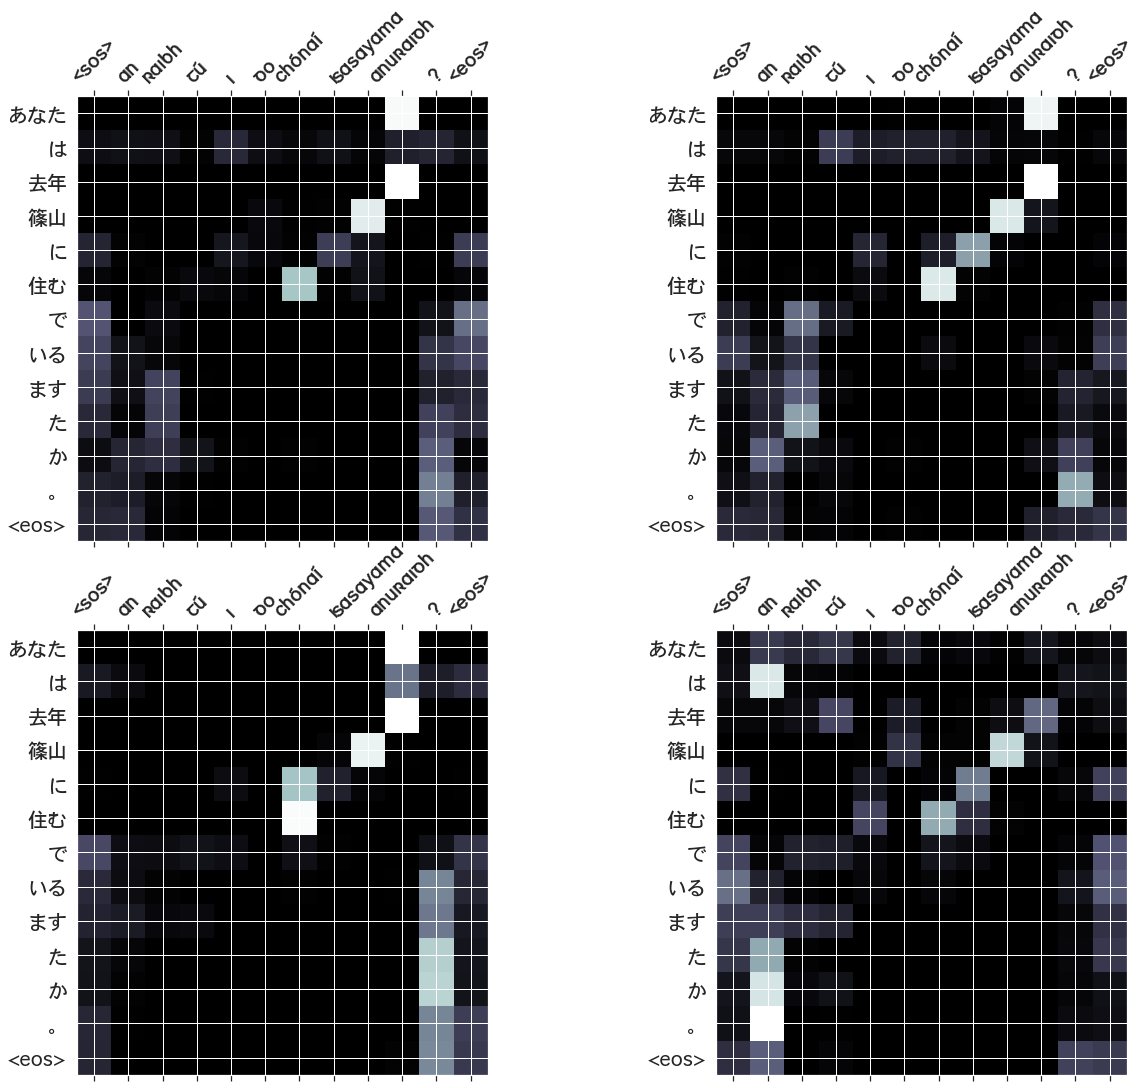

22
src      : thug sé m'ainm air .
trg      : 彼 は 私 の 名前 を 呼ぶ だ 。
predicted: 彼 は 私 の 名前 を 呼ぶ だ 。 <eos>
     blue: 100.00%


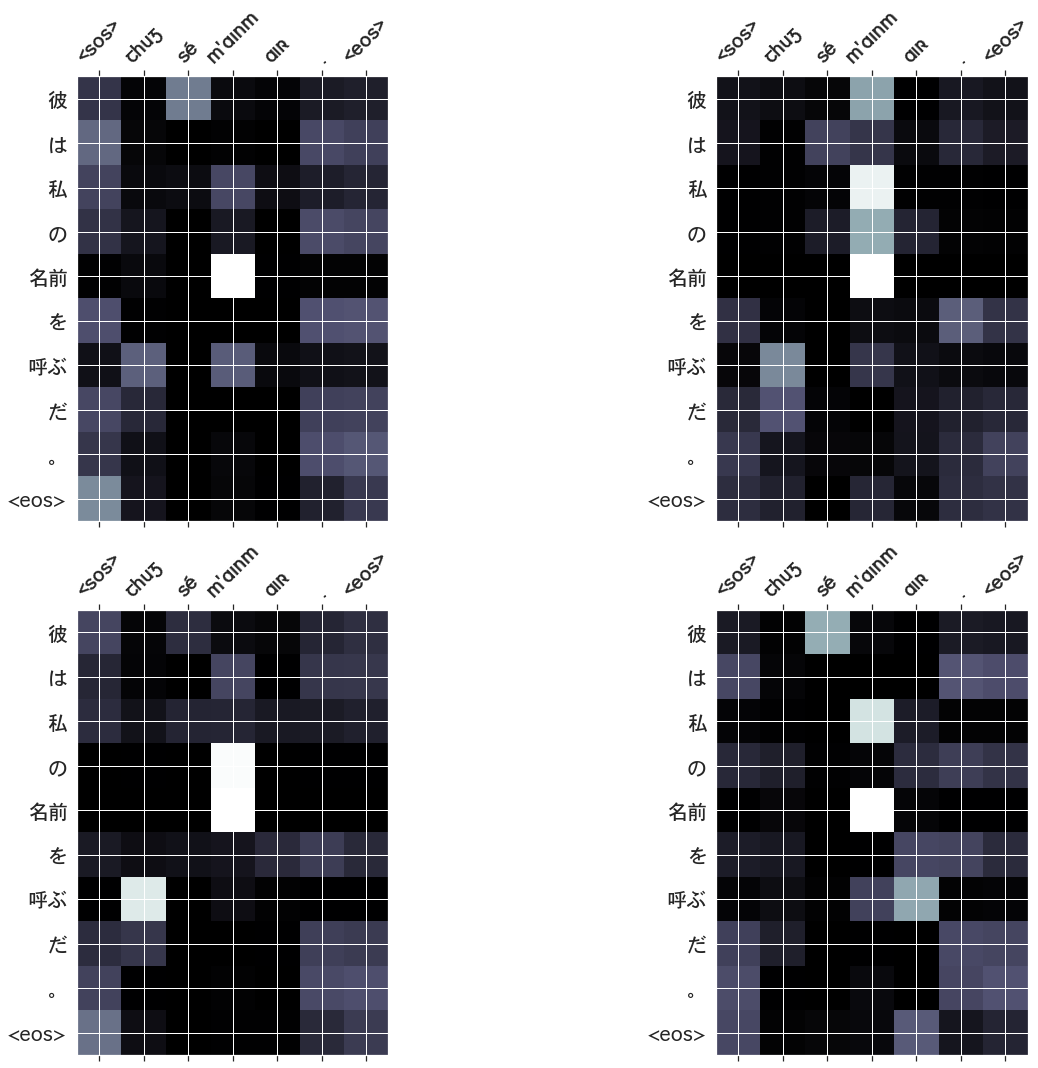

23
src      : caithfidh mé maireachtáil ar m'ioncam an - bheag .
trg      : 私 は わずか だ 収入 で 暮らす ぬ ば なる ない 。
predicted: 私 は わずか だ 収入 で 暮らす ぬ ば なる ない 。 <eos>
     blue: 100.00%


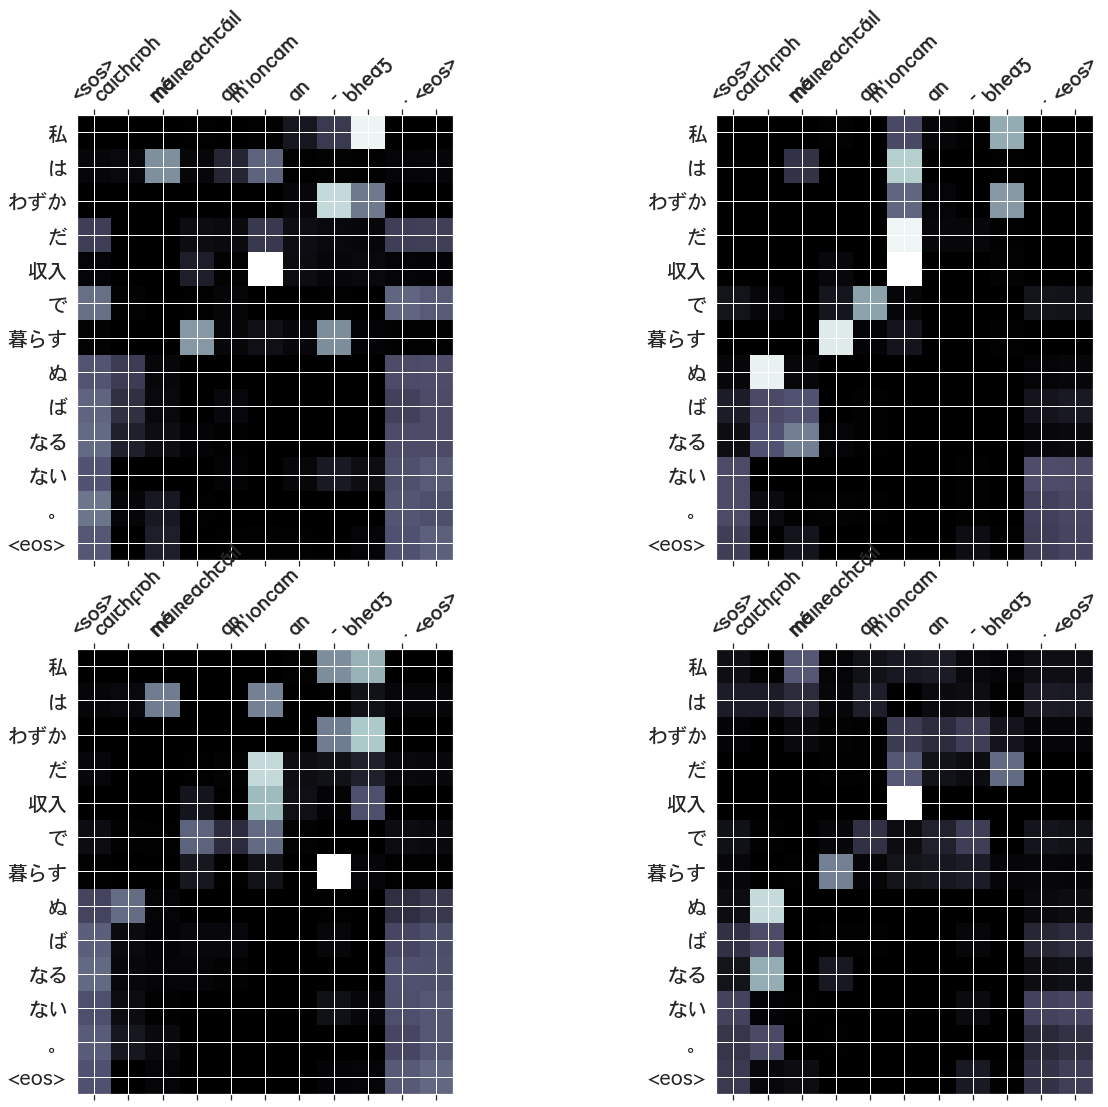

24
src      : cuireadh an dráma i láthair an mhí seo caite .
trg      : その 劇 は 先月 上演 する れる た 。
predicted: その 劇 は 先月 上演 する れる た 。 <eos>
     blue: 100.00%


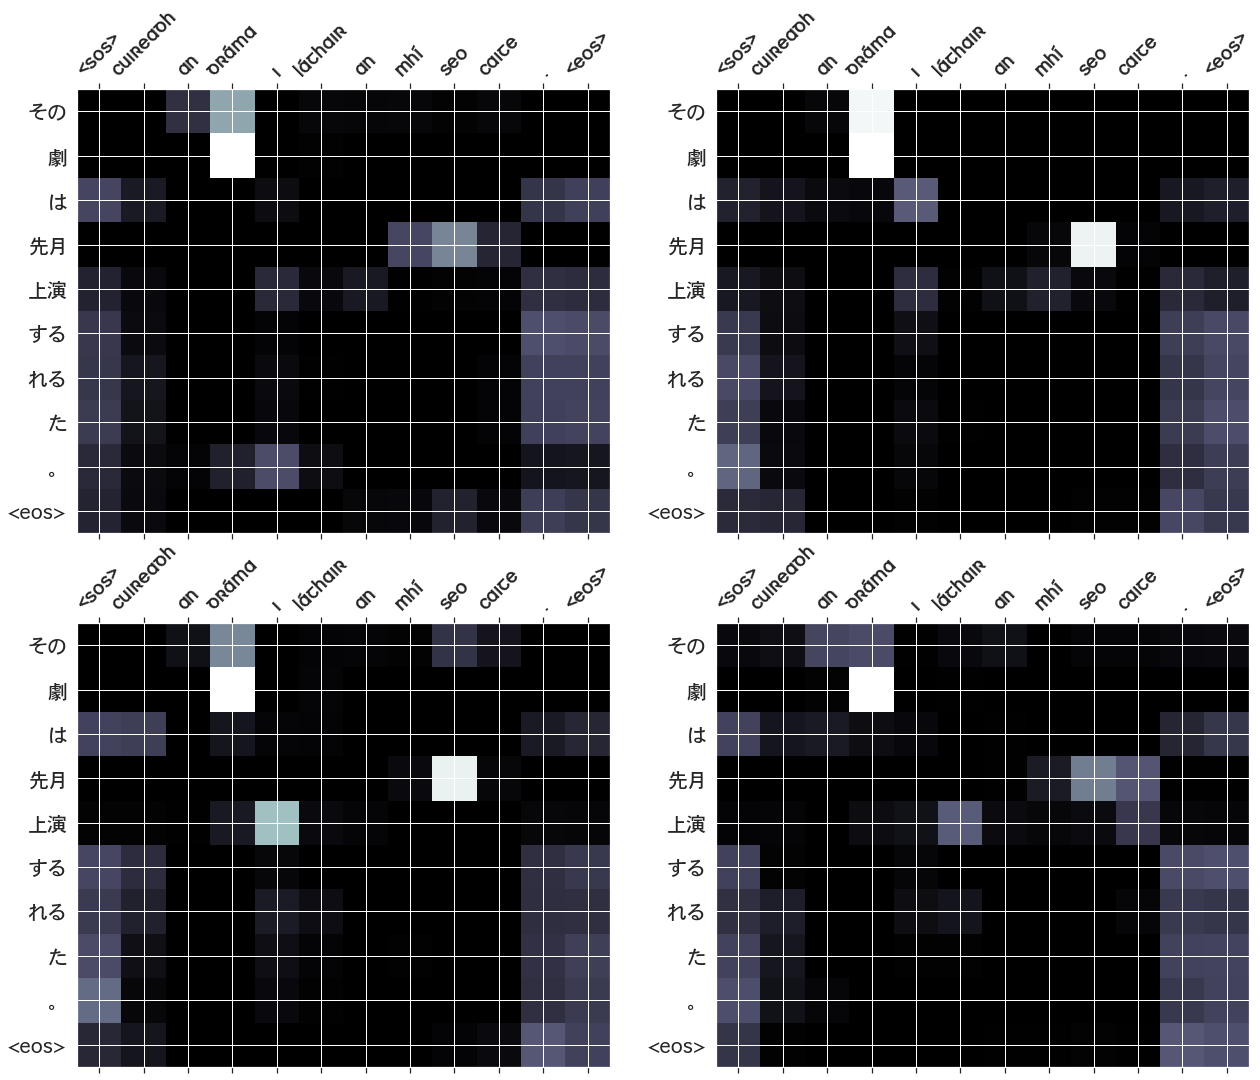

25
src      : críochnóidh mé an obair seo faoi 5 a chlog .
trg      : 私 は ５ 時 まで に この 仕事 を 終える つもり です 。
predicted: 私 は ５ 時 まで に この 仕事 を 終える つもり です 。 <eos>
     blue: 100.00%


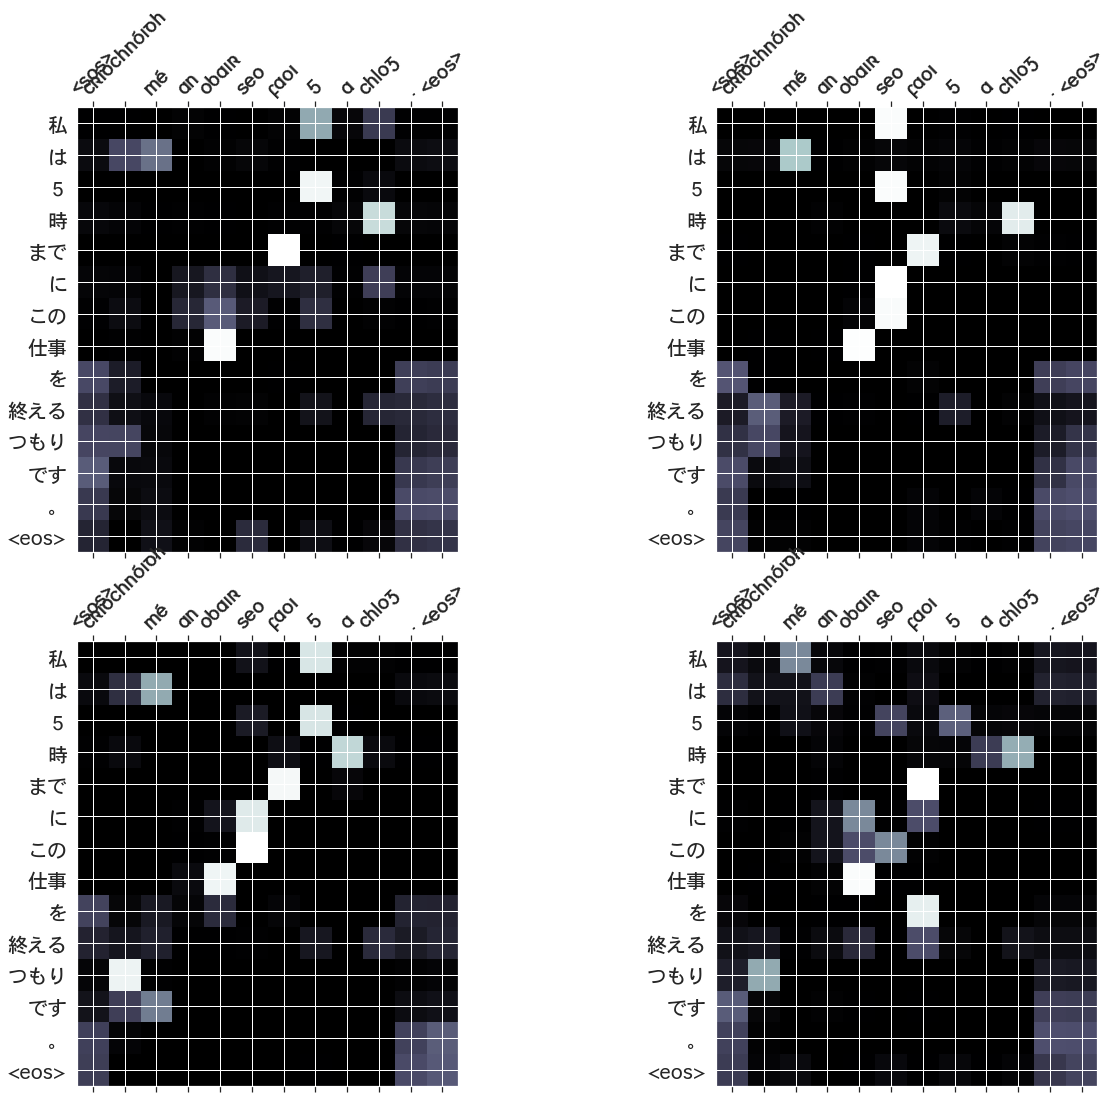

26
src      : tá an abhainn seo go hálainn .
trg      : この 川 は 美しい 。
predicted: この 川 は 美しい 。 <eos>
     blue: 100.00%


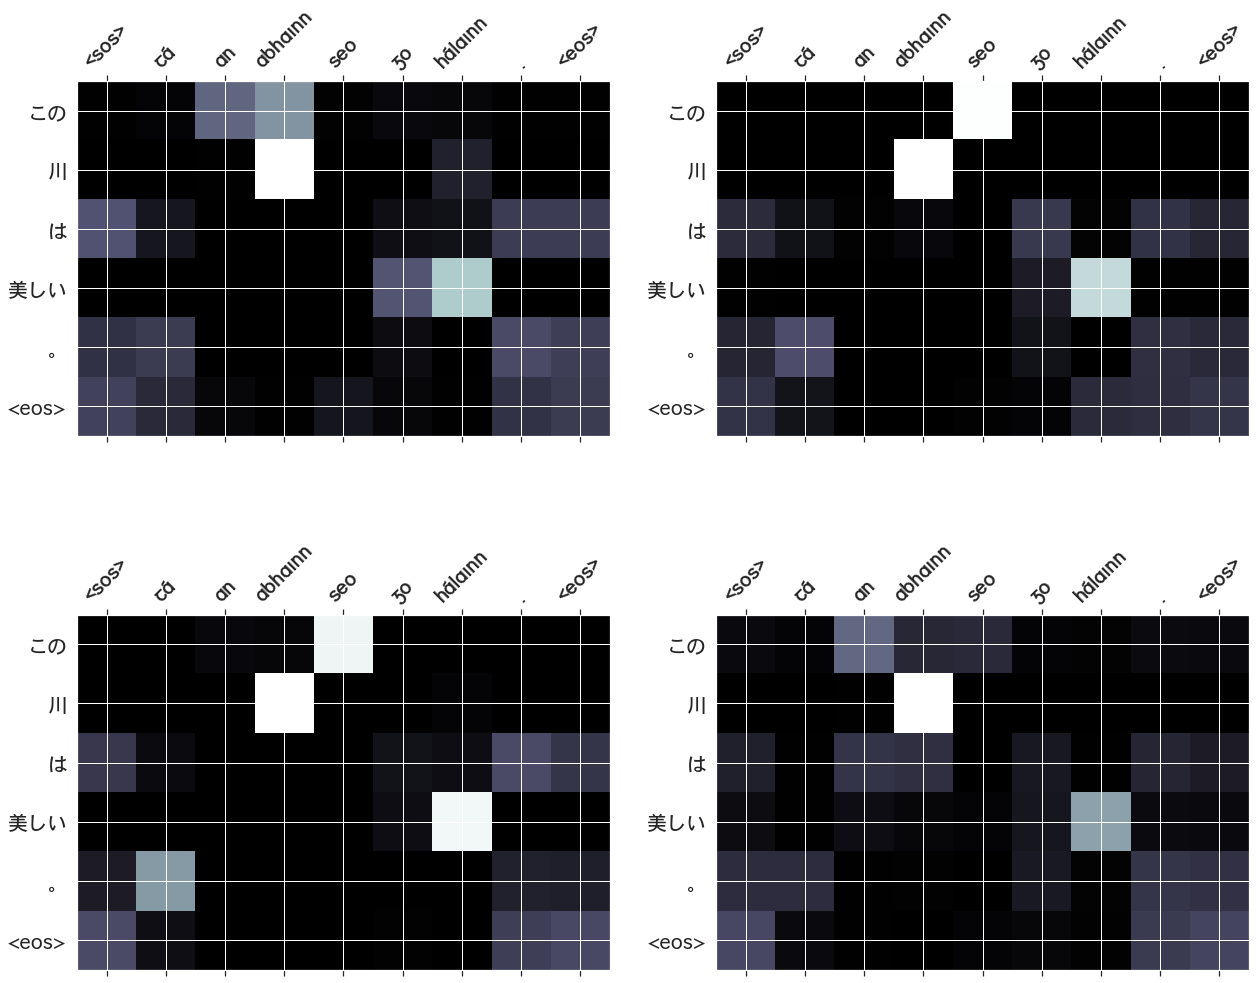

27
src      : tá fiabhras beag orm inniu .
trg      : 今日 は 少し 熱 が ある 。
predicted: 今日 は 少し 熱 が ある 。 <eos>
     blue: 100.00%


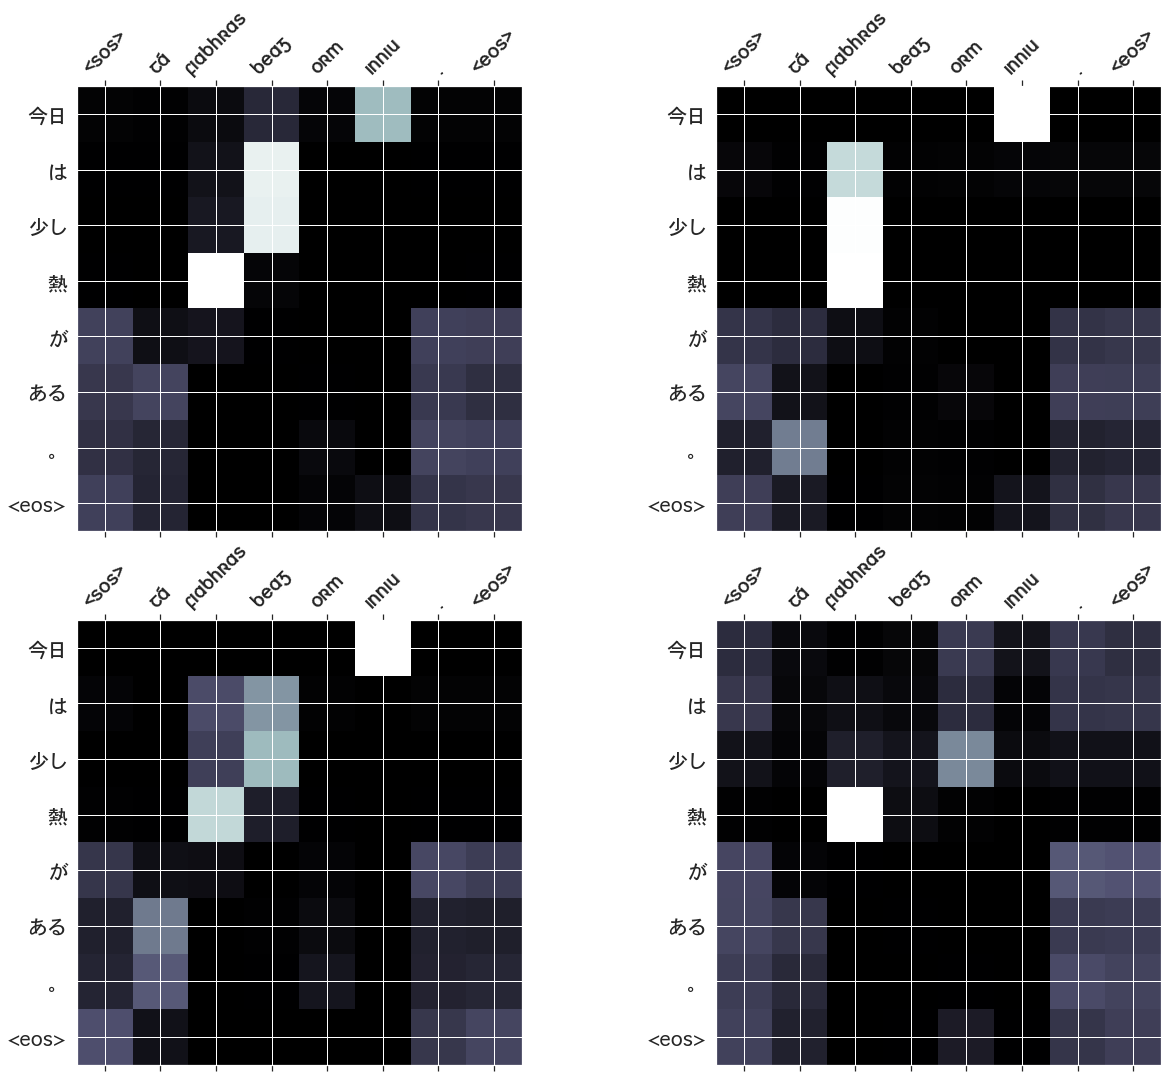

28
src      : is spraoi é cártaí imeartha .
trg      : トランプ は 面白い 。
predicted: トランプ は 面白い 。 <eos>
     blue: 100.00%


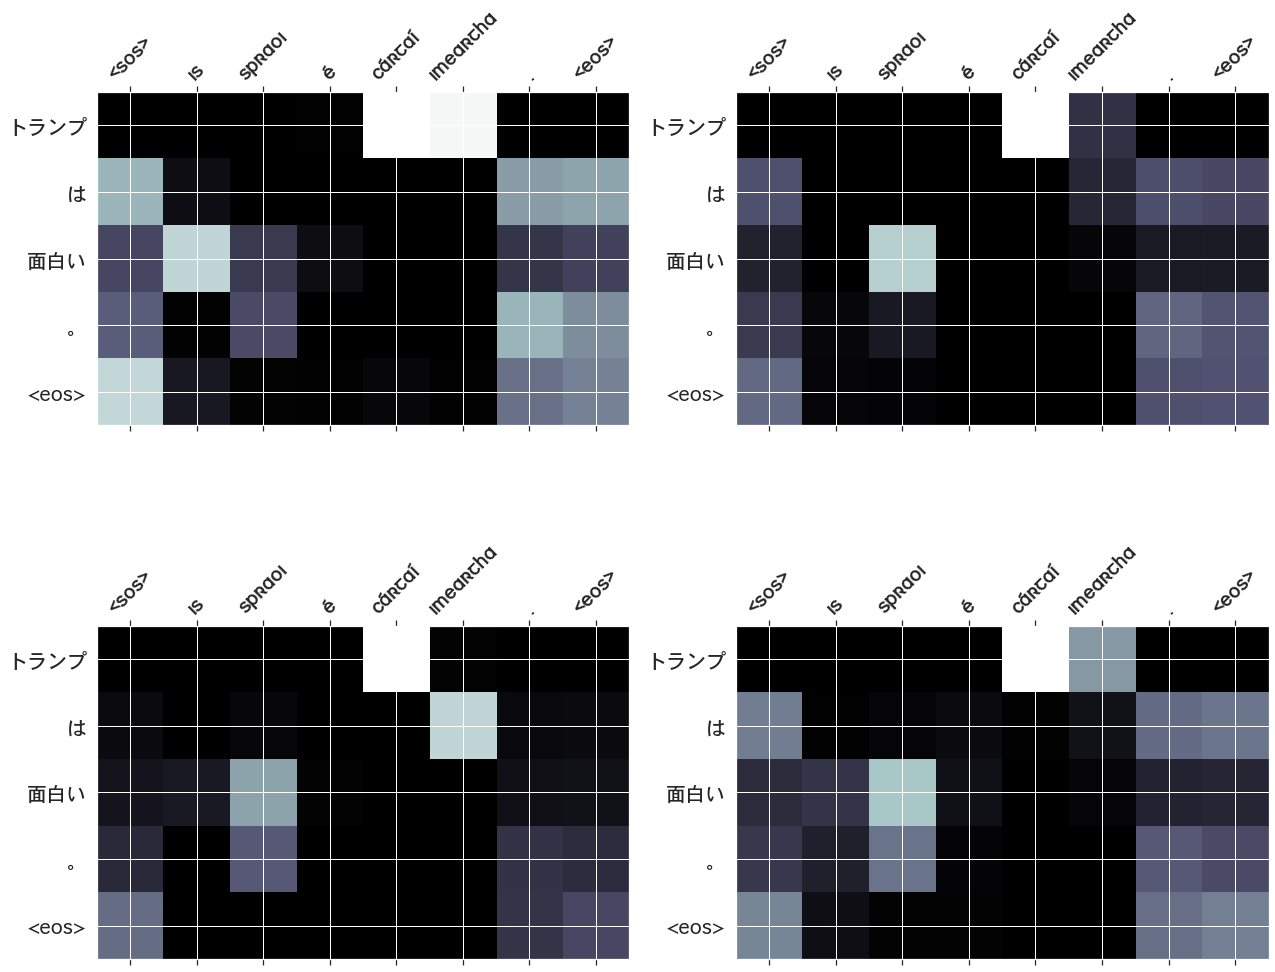

29
src      : bhrath sé mo mhuinín as .
trg      : 彼 は 私 の 信頼 を 裏切る た 。
predicted: 彼 は 私 の 信頼 を 裏切る た 。 <eos>
     blue: 100.00%


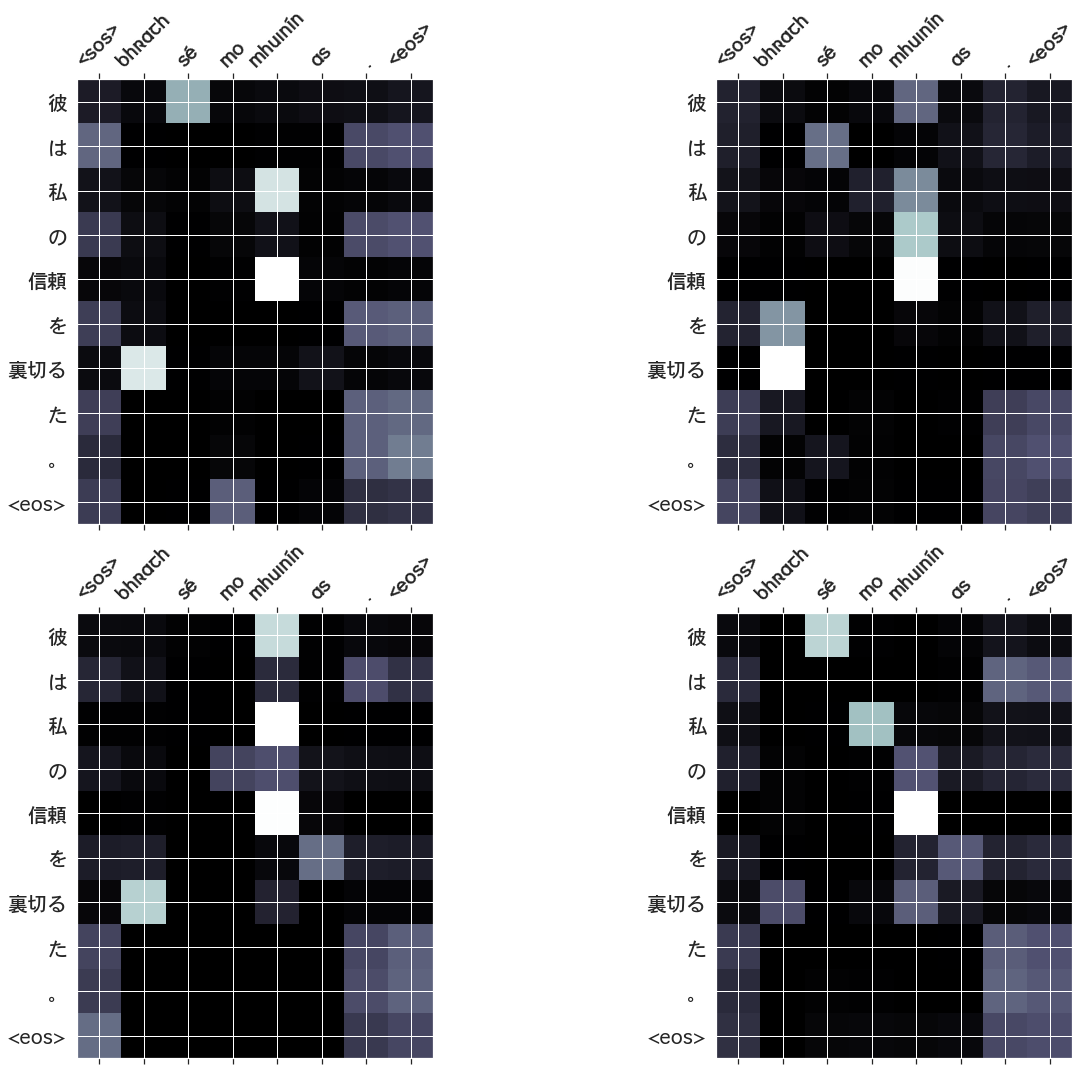

30
src      : tá an chuideachta lonnaithe i mbruachbhailte osaka .
trg      : その 会社 は 大阪 の 郊外 に ある 。
predicted: その 会社 は 大阪 の 郊外 に ある 。 <eos>
     blue: 100.00%


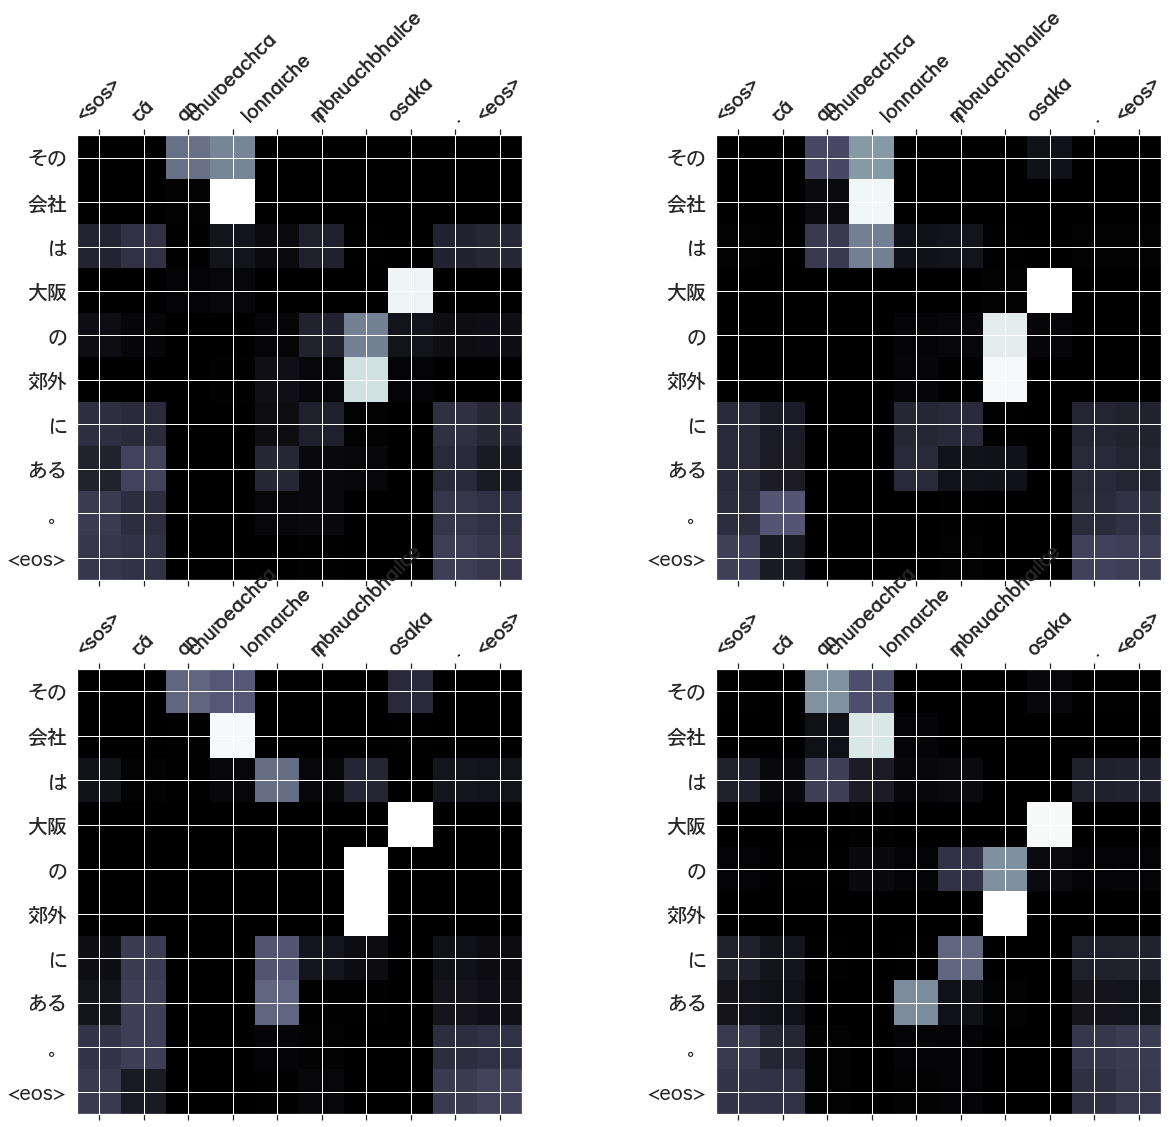

31
src      : chuir siad an príosúnach faoi shaoirse .
trg      : 彼ら は 囚人 を 釈放 する た 。
predicted: 彼ら は 囚人 を 釈放 する た 。 <eos>
     blue: 100.00%


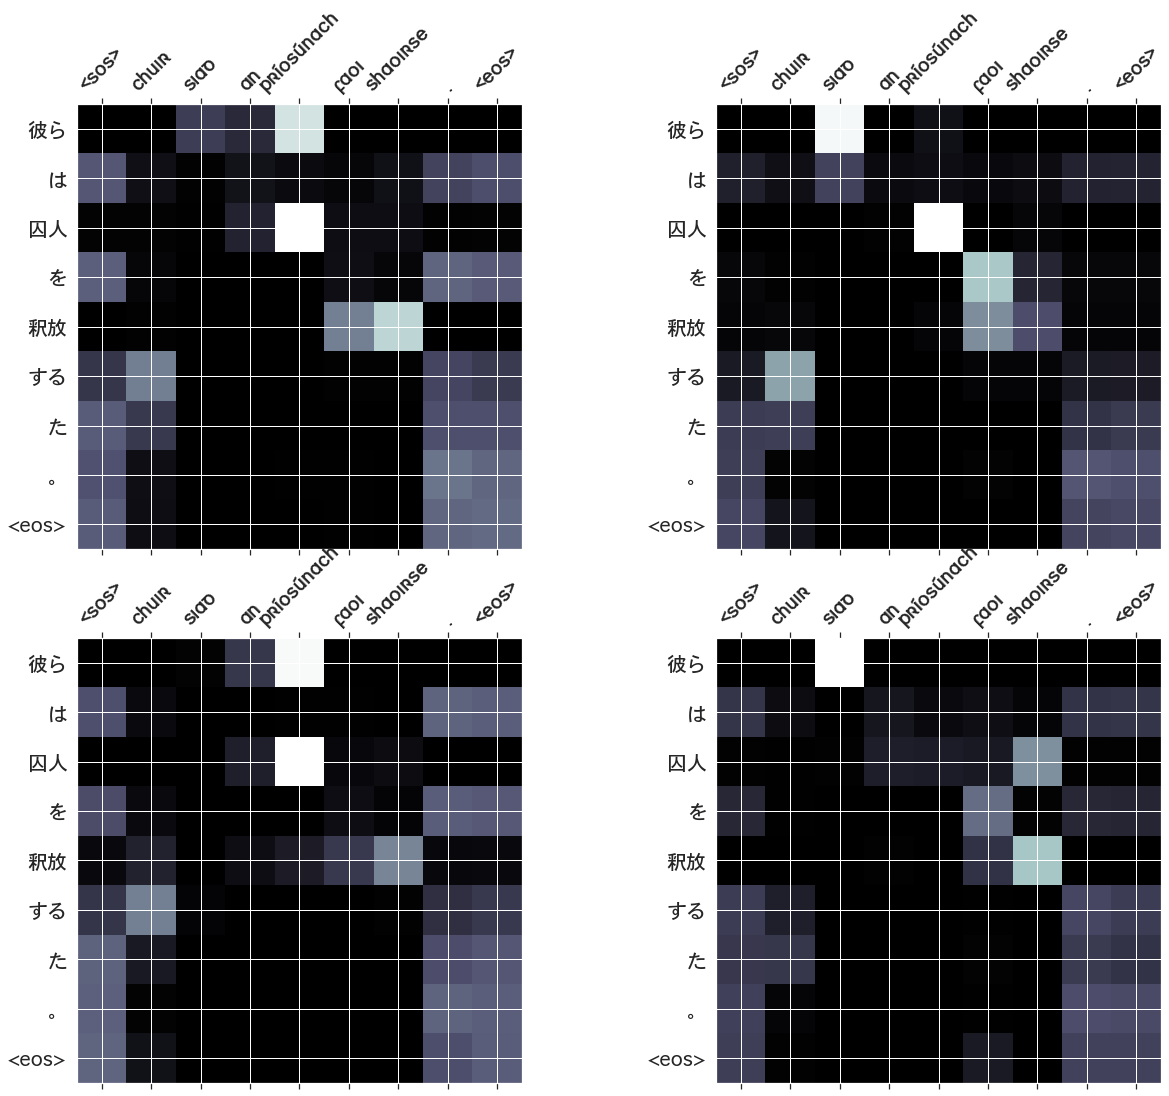

32
src      : caithfidh tú an rud atá ceart a dhéanamh i gcónaí .
trg      : 常に 正しい こと を する ない ば なる ない 。
predicted: 常に 正しい こと を する ない ば なる ない 。 <eos>
     blue: 100.00%


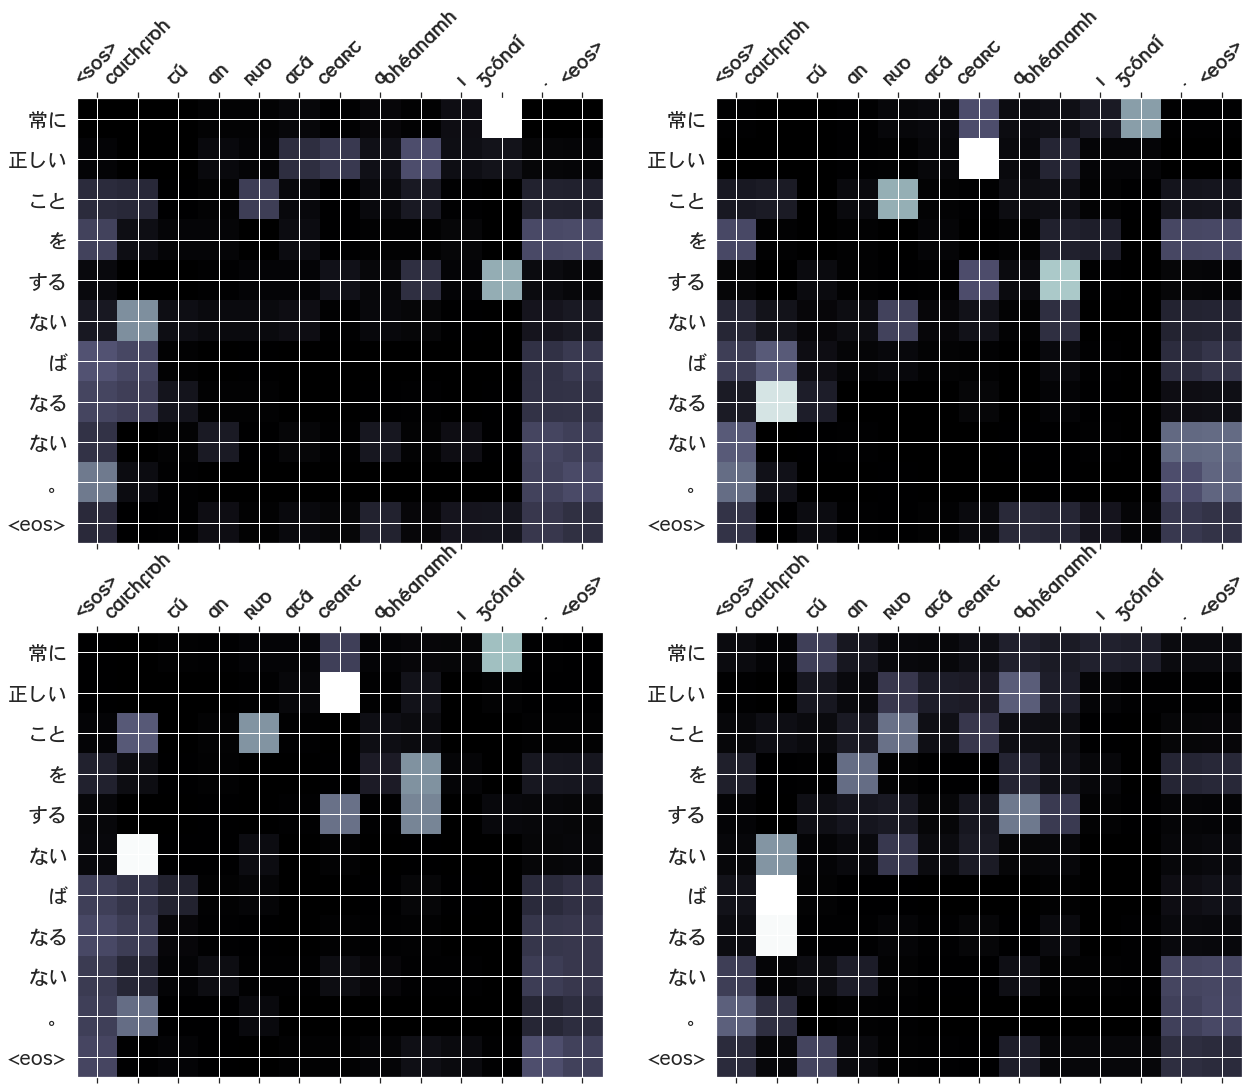

33
src      : níl aon scoil ann inniu .
trg      : 今日 は 学校 が ない 。
predicted: 今日 は 学校 が ない 。 <eos>
     blue: 100.00%


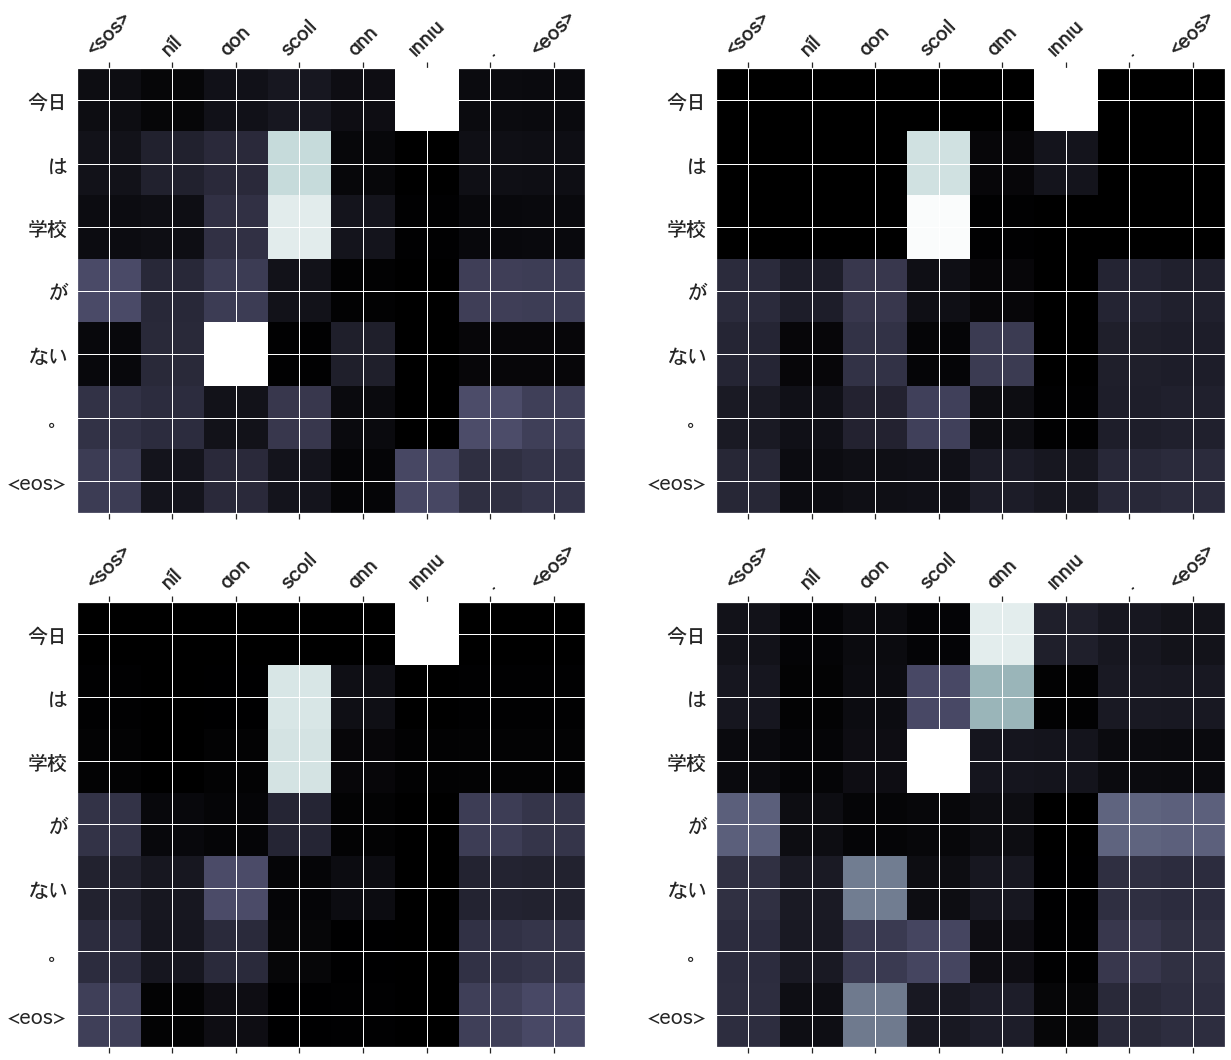

In [47]:
idxs = list(range(len(test_data)))
random.shuffle(idxs)

count = 1

for example_idx in idxs:
    # example_idx = random.randint(0, 1219)
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    translation, attention = translate_sentence(src, SRC, TRG, model, device, max_trg, src_tokenize)
    result = [translation[0]]
    
    blue = sentence_blue(trg, translation, 4)
    if blue < .9:
        continue


    for token in translation:
        if token != result[-1]:
            result.append(token)
    if reverse_src:
        src.reverse()

    if reverse_trg:
        trg.reverse()
        translation.reverse()

    print(count)

    print(f'src      : {" ".join(src)}')
    print(f'trg      : {" ".join(trg)}')
    print(f'predicted: {" ".join(translation)}')
    print(f'     blue: {100 * blue:.2f}%')
    display_attention(src, translation, attention, n_heads = DEC_HEADS, n_rows = DEC_HEADS/2, n_cols = 2, fontprop_x=fontprop_x, fontprop_y=fontprop_y, reverse_trg=reverse_trg)

    count += 1
    if count > 50:
        break